In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as sf
import plotly.express as px

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import PolynomialFeatures
from IPython.display import Image
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
warnings.filterwarnings("ignore")

### Task 1 : Linear and Non-Linear (polynomial) regression models to compare trends for  state  ALABAMA

### For my member task, I used the code from the team task as I  have written that code for linear Regression in the team task.  

In [2]:
#Read the dataset
covid_supermerged_data = pd.read_csv('../../../../data/superdataset.csv')
covid_supermerged_data

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population
0,0,statewide unallocated,AL,2020-01-22,0,0,0
1,0,statewide unallocated,AL,2020-01-23,0,0,0
2,0,statewide unallocated,AL,2020-01-24,0,0,0
3,0,statewide unallocated,AL,2020-01-25,0,0,0
4,0,statewide unallocated,AL,2020-01-26,0,0,0
...,...,...,...,...,...,...,...
2346471,56045,weston county,WY,2022-02-03,1491,17,6927
2346472,56045,weston county,WY,2022-02-04,1496,17,6927
2346473,56045,weston county,WY,2022-02-05,1496,17,6927
2346474,56045,weston county,WY,2022-02-06,1496,17,6927


#### Removed the unwanted data and sum the cases and deaths by date

In [3]:
#Retrieving the data with State = 'AL'
AL_data= covid_supermerged_data[covid_supermerged_data['State']=="AL"]

In [4]:
#Remove the unallocated county from the dataset
AL_data = AL_data[AL_data['County_Name']!='statewide unallocated']

In [5]:
#Find the difference of the two columns Confirmed and Deaths
AL_data['Num of Cases per day'] = AL_data['Confirmed'].diff()
AL_data['Num of Deaths per day'] = AL_data['Deaths'].diff()
AL_data = AL_data.drop([748])

In [6]:
# removing the row that contains NAN 
AL_data= AL_data[AL_data['Date'] != '2020-01-22']
AL_data['Date'] = AL_data.Date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))

In [7]:
AL_data_groupedBydate = AL_data.groupby("Date").sum().reset_index()

#### Remove all the zeros from the dataframe column cases and deaths

*  https://stackoverflow.com/questions/63361261/how-to-remove-rows-from-a-dataframe-where-some-columns-only-have-zero-values

In [8]:
AL_data_groupedBydate = AL_data_groupedBydate[(AL_data_groupedBydate[['Num of Cases per day']] != 0).any(axis=1)]
AL_data_groupedBydate = AL_data_groupedBydate[(AL_data_groupedBydate[['Num of Deaths per day', 'Num of Deaths per day']] != 0).any(axis=1)]
AL_data_groupedBydate

,Date,countyFIPS,Confirmed,Deaths,population,Num of Cases per day,Num of Deaths per day
62,2020-03-25,71489,386,1,4903185,144.0,1.0
64,2020-03-27,71489,639,2,4903185,108.0,1.0
65,2020-03-28,71489,717,3,4903185,78.0,1.0
66,2020-03-29,71489,825,4,4903185,108.0,1.0
67,2020-03-30,71489,941,6,4903185,116.0,2.0
...,...,...,...,...,...,...,...
729,2022-01-21,71489,1120881,16824,4903185,16525.0,32.0
732,2022-01-24,71489,1153149,16826,4903185,32268.0,2.0
740,2022-02-01,71489,1229300,17215,4903185,76151.0,389.0
743,2022-02-04,71489,1240496,17371,4903185,11196.0,156.0


#### Generate first occurence of days  in the dataframe.

For this task I used the code from the team task as I have written this code. I basically added a index column and renamed as Days to generate the occurence of days in the dataframe.

* https://stackoverflow.com/questions/38862293/how-to-add-incremental-numbers-to-a-new-column-using-pandas

In [9]:
AL_data_groupedBydate = AL_data_groupedBydate.assign( Days =[1 + i for i in range(len(AL_data_groupedBydate))])[['Days'] + AL_data_groupedBydate.columns.tolist()]

#### Creating a dataframe with the columns that I might need for the task

####  Adding the days column towards the end of the dataframe

For convenience I concatenated the days column to the end of the dataframe.

* https://stackoverflow.com/questions/58228837/best-way-to-move-a-column-in-pandas-dataframe-to-last-column-in-large-dataframe

In [10]:
s = AL_data_groupedBydate.pop('Days')
AL_data_groupedBydate = pd.concat([AL_data_groupedBydate, s], 1)
AL_data_groupedBydate.tail()

,Date,countyFIPS,Confirmed,Deaths,population,Num of Cases per day,Num of Deaths per day,Days
729,2022-01-21,71489,1120881,16824,4903185,16525.0,32.0,512
732,2022-01-24,71489,1153149,16826,4903185,32268.0,2.0,513
740,2022-02-01,71489,1229300,17215,4903185,76151.0,389.0,514
743,2022-02-04,71489,1240496,17371,4903185,11196.0,156.0,515
746,2022-02-07,71489,1245876,17387,4903185,5380.0,16.0,516


### I used the Linear Regression model  and the function to calculate RMSE from the team task as I have written the code and also I have referred the above links to do the task

#### Implement Linear Regression Model

* https://towardsdatascience.com/an-introduction-to-linear-regression-for-data-science-9056bbcdf675
* https://stackoverflow.com/questions/29934083/linear-regression-on-pandas-dataframe-using-sklearn-indexerror-tuple-index-ou

### Linear Regression Model for New cases -- ALABAMA STATE

In [11]:
#Getting the X and Y values from the dataframe
X1 = AL_data_groupedBydate[['Days']].to_numpy()
y1 = AL_data_groupedBydate['Num of Cases per day'].to_numpy()

In [12]:
#splitting the data
x_train, x_test, y_train, y_test = train_test_split(X1, y1)

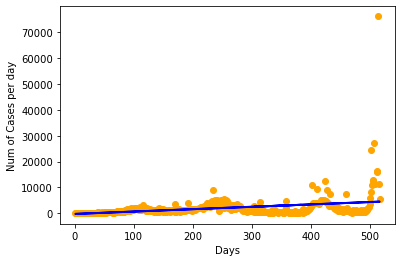

In [13]:
#creating a linear model and predicting the values
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(x_train, y_train)
plt.scatter(x_train, y_train, color='orange')
plt.plot(x_train, model1.predict(x_train),color='blue', linewidth=2)
plt.xlabel('Days')
plt.ticklabel_format(style='plain')
plt.ylabel('Num of Cases per day')
plt.show()

In [14]:
modelPred = model1.predict(x_test)

#### I refered the below site to calculate RMSE value
* https://stackoverflow.com/questions/45173451/scikit-learn-how-to-calculate-root-mean-square-error-rmse-in-percentage

For RMSE calculate I created a function so that I can use in all my tasks. 

In [15]:
#Calculating RMSE
def cal_rmse(a,b):
    meanSquaredError=mean_squared_error(a, b)
    print("MSE:", meanSquaredError)
    rootMeanSquaredError = np.sqrt(meanSquaredError)
    print("RMSE:", rootMeanSquaredError)

In [16]:
cal_rmse(y_test, modelPred)

MSE: 35803857.0279668
RMSE: 5983.632427544893


### Confidence Interval

### I calculated the confidence interval using regplots of seaborn. The color difference  around the regression line is a upper and lower bounds of confidence interval

<AxesSubplot:>

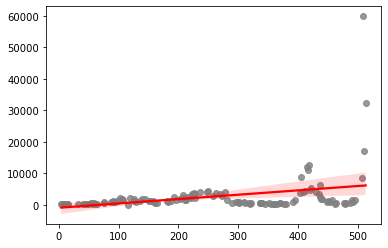

In [17]:
import seaborn as sns
#ax = sns.regplot(X1, y1 , ci=80)
sns.regplot(x=x_test, y = y_test, data= AL_data_groupedBydate, scatter_kws={"color": "grey"}, line_kws={"color": "red"})

### Linerar Regression for New deaths  - ALABMA STATE

In [18]:
X2 = AL_data_groupedBydate[['Days']].to_numpy()
y2 = AL_data_groupedBydate['Num of Deaths per day'].to_numpy()

In [19]:
x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(X2, y2)

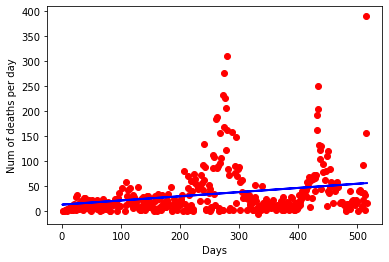

In [20]:
from sklearn.linear_model import LinearRegression
model2 = LinearRegression()
model2.fit(x_train_t, y_train_t)
plt.scatter(x_train_t, y_train_t,  color='red')
plt.plot(x_train_t, model2.predict(x_train_t), color='blue', linewidth=2)
plt.xlabel('Days')
plt.ticklabel_format(style='plain')
plt.ylabel('Num of deaths per day')
plt.show()

In [21]:
modelPred_t = model2.predict(x_test_t)

In [22]:
#calculating RMSE values from the above defined function
cal_rmse(y_test_t, modelPred_t)

MSE: 1599.01526439542
RMSE: 39.98768891040616


### Confindence Interval

### Confidence Interval for Deaths - The color difference around the regression line are the upper and lower bounds of the intervals

<AxesSubplot:>

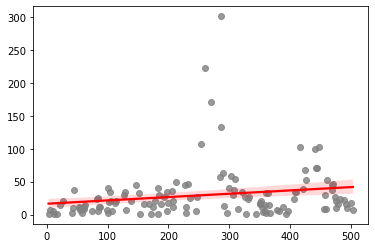

In [23]:
import seaborn as sns
#ax = sns.regplot( X2, y2, ci=80)
sns.regplot(x= x_test_t, y = y_test_t, data= AL_data_groupedBydate, scatter_kws={"color": "grey"}, line_kws={"color": "red"})

### Prediction of new cases and deaths  for Alabama state

To perform the below task I referred the code from the team Task and generated the values for future dates and built a dataframe so as to plot the values generated. 

In [24]:
#Predicting the values
new_dates = modelPred[:10]
new_dates = list(new_dates)
new_dates = np.arange(748,758).reshape(-1,1)

In [25]:

#new cases forecast for 7 days
new_cases = model1.predict(new_dates)
new_deaths = model2.predict(new_dates)

p = pd.DataFrame(new_cases)
r = pd.DataFrame(new_deaths)
df_added = AL_data_groupedBydate
frames = [df_added['Num of Cases per day'], p]
result = pd.concat(frames)
# deaths
frames2 = [df_added['Num of Deaths per day'], r]
result2 = pd.concat(frames2)
p = pd.DataFrame(new_cases)
r = pd.DataFrame(new_deaths)

frames = [df_added['Num of Cases per day'], p]
result = pd.concat(frames)

# deaths
frames2 = [df_added['Num of Deaths per day'], r]
result2 = pd.concat(frames2)

result.rename(columns = {0: 'Num of Cases per day'}, inplace = True)
result2.rename(columns = {0: 'Num of Deaths per day'}, inplace = True)

q = pd.DataFrame(new_dates)
frames1 = [df_added['Days'], q]
result1 = pd.concat(frames1)
result1.rename(columns = {0: 'Days'}, inplace = True)

df1 = pd.concat([result, result1,result2], axis=1)
df1

,Num of Cases per day,Days,Num of Deaths per day
62,144.000000,1,1.000000
64,108.000000,2,1.000000
65,78.000000,3,1.000000
66,108.000000,4,1.000000
67,116.000000,5,2.000000
...,...,...,...
5,6712.838216,753,76.236956
6,6722.051989,754,76.320228
7,6731.265763,755,76.403500
8,6740.479536,756,76.486772


### Trendline and Prediction plot for New Cases

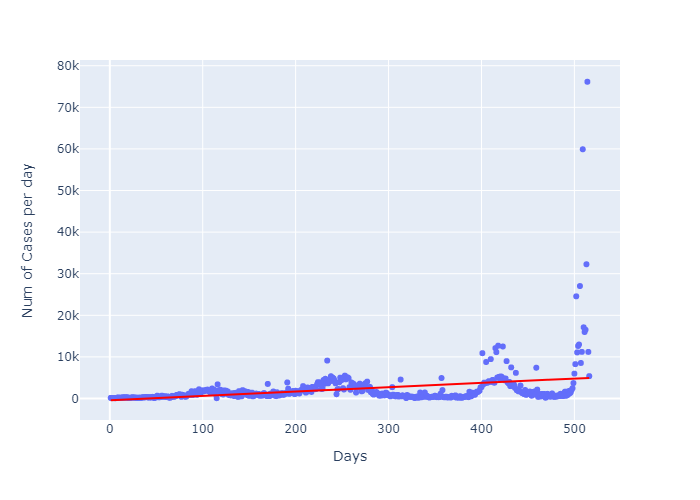

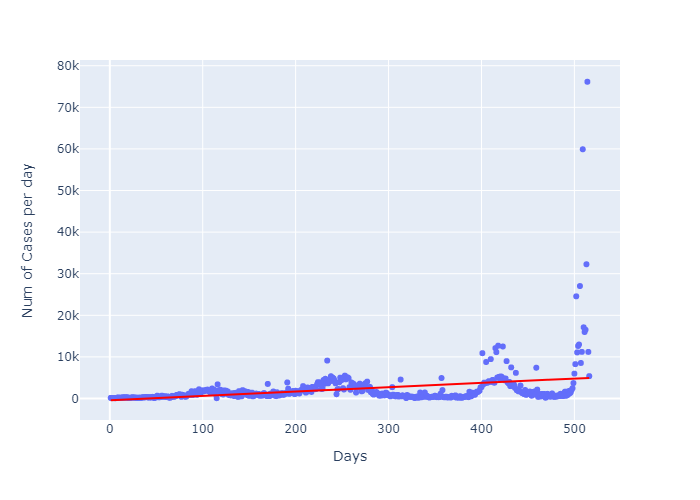

In [28]:
#original 747 columns
df = AL_data_groupedBydate

fig = px.scatter(AL_data_groupedBydate, x="Days", y="Num of Cases per day", trendline="ols",trendline_color_override="red")
#fig.show()
fig.write_image("1.png")
Image(filename="1.png")

### Trendline and Prediction plot for New Deaths

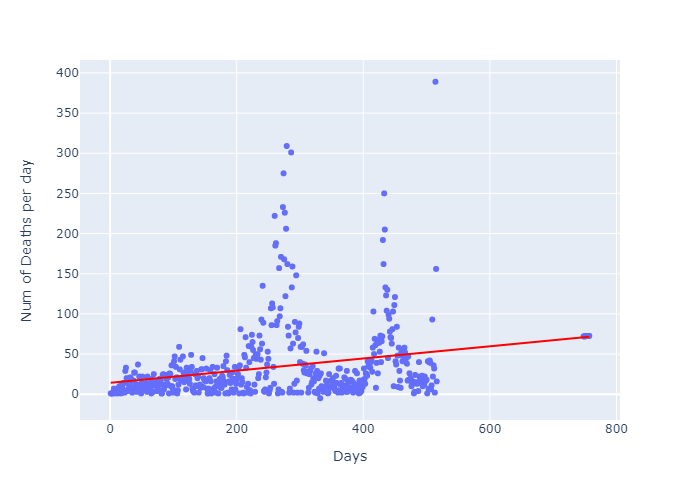

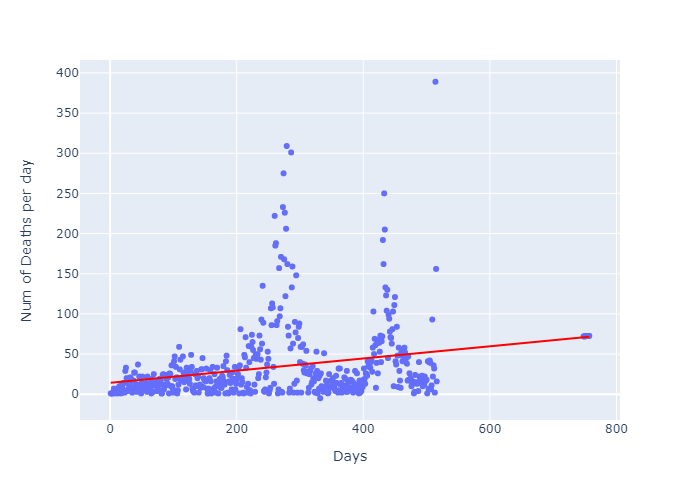

In [29]:
#UPdated forecast for 10 days
fig = px.scatter(df1, x="Days", y="Num of Deaths per day", trendline="ols", trendline_color_override="red")
#fig.show()
fig.write_image("2.png")
Image(filename="2.png")

In [26]:
def model_summary( model , xvalue , yvalue):
    model = sm.OLS(yvalue,xvalue)
    fitted_model = model.fit()
    a = fitted_model.summary()
    return a

In [27]:
model_summary(model2 , X2 , y2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.363
Model:                            OLS   Adj. R-squared (uncentered):              0.362
Method:                 Least Squares   F-statistic:                              294.0
Date:                Wed, 27 Apr 2022   Prob (F-statistic):                    1.79e-52
Time:                        12:12:26   Log-Likelihood:                         -2708.1
No. Observations:                 516   AIC:                                      5418.
Df Residuals:                     515   BIC:                                      5422.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1166      0.007     17.148      0.000       0.103       0.130
==============================================================================
Omnibus:                      357.698   Durbin-Watson:                   0.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4247.074
Skew:                           2.962   Prob(JB):                         0.00
Kurtosis:                      15.746   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
model_summary(model1 , X1 , y1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.235
Model:                            OLS   Adj. R-squared (uncentered):              0.234
Method:                 Least Squares   F-statistic:                              158.6
Date:                Wed, 27 Apr 2022   Prob (F-statistic):                    6.78e-32
Time:                        12:12:27   Log-Likelihood:                         -5121.1
No. Observations:                 516   AIC:                                  1.024e+04
Df Residuals:                     515   BIC:                                  1.025e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             9.1939      0.730     12.594      0.000       7.760      10.628
==============================================================================
Omnibus:                      834.841   Durbin-Watson:                   1.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           297808.540
Skew:                           9.373   Prob(JB):                         0.00
Kurtosis:                     119.190   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Non-Linear (polynomial) Regression for New cases  for the state of ALABAMA

#### I referred the below sites to understand about polynomial regression and implemented the code with its reference

## Non-Linear (polynomial) regression for Cases

I have referred the below site to perform the polynomial regression.

* https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386
* https://towardsdatascience.com/polynomial-regression-bbe8b9d97491
* https://youtu.be/SSmpyoIdJTc
* https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386

In [29]:
X1 = AL_data_groupedBydate[['Days']]
y1 = AL_data_groupedBydate['Num of Cases per day']

X1 = X1.to_numpy()
y1 = y1.to_numpy()

RMSE of degree 2  :  4847.86432007949
RMSE of degree 3 :  4617.730607622961
RMSE of degree 4  :  4428.660224694491


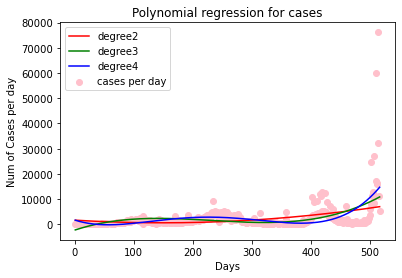

In [30]:
polynomial_feature_2 = PolynomialFeatures(degree=2)
x_poly2 = polynomial_feature_2.fit_transform(X1)
model = LinearRegression()
model.fit(x_poly2, y1)
y_poly_pred = model.predict(x_poly2)
rmse = np.sqrt(mean_squared_error(y1,y_poly_pred))
print("RMSE of degree 2  : " , rmse)

polynomial_feature_3 = PolynomialFeatures(degree=3)
x_poly3 = polynomial_feature_3.fit_transform(X1)
poly_reg3 = LinearRegression()
poly_reg3.fit(x_poly3, y1)
y_poly_pred3 = poly_reg3.predict(x_poly3)
rmse = np.sqrt(mean_squared_error(y1,y_poly_pred3))
print("RMSE of degree 3 : " , rmse)


polynomial_feature_4 = PolynomialFeatures(degree=4)
x_poly4 = polynomial_feature_4.fit_transform(X1)
poly_reg4 = LinearRegression()
poly_reg4.fit(x_poly4, y1)
y_poly_pred4 = poly_reg4.predict(x_poly4)

rmse = np.sqrt(mean_squared_error(y1,y_poly_pred4))
print("RMSE of degree 4  : " ,rmse)

plt.scatter(X1, y1, color = 'pink')
plt.plot(X1, model.predict(x_poly2), color = 'r') 
plt.plot(X1, poly_reg3.predict(x_poly3), color = 'g') 
plt.plot(X1, poly_reg4.predict(x_poly4), color = 'b') 
plt.xlabel('Days')
plt.ylabel('Num of Cases per day')
plt.title("Polynomial regression for cases")
plt.legend(["degree2","degree3","degree4" , "cases per day"], loc ="upper left")
plt.show()

In [31]:
def model_summary( model , xvalue , yvalue):
    model = sm.OLS(yvalue,xvalue)
    fitted_model = model.fit()
    a = fitted_model.summary()
    return a

### Checking the model summary for all the models generated
* https://github.com/UNCG-CSE/CSC-405-605_Spring_2022/blob/main/Class_Resources/Lecture_06/Statistics/07_linear_regression.ipynb

In [32]:
a = model_summary(model , X1 , y1)
b = model_summary(poly_reg3 , X1 , y1)
c = model_summary(poly_reg4 , X1 , y1)

In [33]:
a

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.235
Model:                            OLS   Adj. R-squared (uncentered):              0.234
Method:                 Least Squares   F-statistic:                              158.6
Date:                Wed, 27 Apr 2022   Prob (F-statistic):                    6.78e-32
Time:                        12:12:35   Log-Likelihood:                         -5121.1
No. Observations:                 516   AIC:                                  1.024e+04
Df Residuals:                     515   BIC:                                  1.025e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             9.1939      0.730     12.594      0.000       7.760      10.628
==============================================================================
Omnibus:                      834.841   Durbin-Watson:                   1.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           297808.540
Skew:                           9.373   Prob(JB):                         0.00
Kurtosis:                     119.190   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
b

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.235
Model:                            OLS   Adj. R-squared (uncentered):              0.234
Method:                 Least Squares   F-statistic:                              158.6
Date:                Wed, 27 Apr 2022   Prob (F-statistic):                    6.78e-32
Time:                        12:12:35   Log-Likelihood:                         -5121.1
No. Observations:                 516   AIC:                                  1.024e+04
Df Residuals:                     515   BIC:                                  1.025e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             9.1939      0.730     12.594      0.000       7.760      10.628
==============================================================================
Omnibus:                      834.841   Durbin-Watson:                   1.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           297808.540
Skew:                           9.373   Prob(JB):                         0.00
Kurtosis:                     119.190   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
c

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.235
Model:                            OLS   Adj. R-squared (uncentered):              0.234
Method:                 Least Squares   F-statistic:                              158.6
Date:                Wed, 27 Apr 2022   Prob (F-statistic):                    6.78e-32
Time:                        12:12:35   Log-Likelihood:                         -5121.1
No. Observations:                 516   AIC:                                  1.024e+04
Df Residuals:                     515   BIC:                                  1.025e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             9.1939      0.730     12.594      0.000       7.760      10.628
==============================================================================
Omnibus:                      834.841   Durbin-Watson:                   1.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           297808.540
Skew:                           9.373   Prob(JB):                         0.00
Kurtosis:                     119.190   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Prediction and Trendline for New Cases

I referred the below links to get the model summary and also referred the notes 
* https://stackoverflow.com/questions/64148189/linearregression-object-has-no-attribute-summary

This is the trendline for the new predicted values

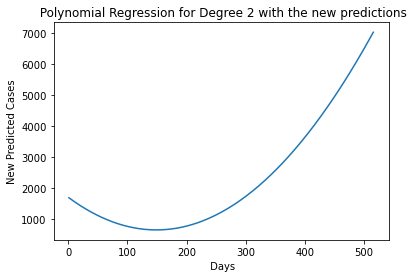

In [36]:
plt.plot( X1 , y_poly_pred )
plt.xlabel(" Days")
plt.ylabel("New Predicted Cases")
plt.title(" Polynomial Regression for Degree 2 with the new predictions" )
plt.show()

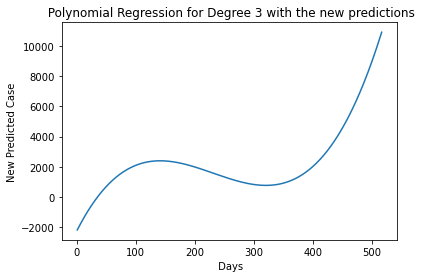

In [37]:
plt.plot( X1 , y_poly_pred3 )
plt.xlabel(" Days")
plt.ylabel("New Predicted Case")
plt.title(" Polynomial Regression for Degree 3 with the new predictions" )
plt.show()

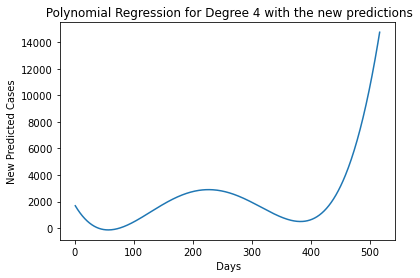

In [38]:
plt.plot( X1 , y_poly_pred4 )
plt.xlabel(" Days")
plt.ylabel("New Predicted Cases")
plt.title(" Polynomial Regression for Degree 4 with the new predictions" )
plt.show()

### Confidence Interval for New Cases - Non Linear 

#### The shaded area around the regression line is the upper and lower bounds of the confidence Intervals

<AxesSubplot:>

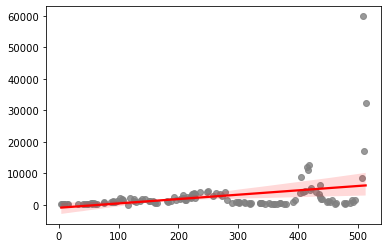

In [39]:
import seaborn as sns
#ax = sns.regplot( X1, y1, ci=80)

sns.regplot(x=x_test, y= y_test, data= AL_data_groupedBydate, scatter_kws={"color": "grey"}, line_kws={"color": "red"})

## Non-Linear (polynomial) regression for Deaths

In [40]:
X2 = AL_data_groupedBydate[['Days']]
y2 = AL_data_groupedBydate['Num of Deaths per day']

X2 = X2.to_numpy()
y2 = y2.to_numpy()

RMSE of degree 2  :  44.96967469827383
RMSE of degree 3 :  44.96802197489154
RMSE of degree 4  :  3485.817711857422


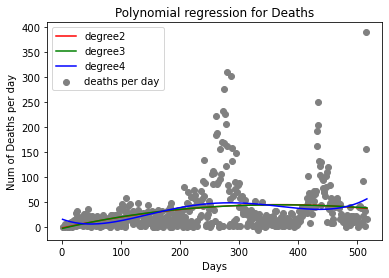

In [41]:
polynomial_feature_2d = PolynomialFeatures(degree=2)
x_poly2d = polynomial_feature_2d.fit_transform(X2)
model_d = LinearRegression()
model_d.fit(x_poly2d, y2)
y_poly_pred_d = model_d.predict(x_poly2d)
rmse = np.sqrt(mean_squared_error(y2,y_poly_pred_d))
print("RMSE of degree 2  : " , rmse)

polynomial_feature_3d = PolynomialFeatures(degree=3)
x_poly3d = polynomial_feature_3d.fit_transform(X2)
poly_reg3d = LinearRegression()
poly_reg3d.fit(x_poly3d, y2)
y_poly_pred3d = poly_reg3d.predict(x_poly3d)
rmse = np.sqrt(mean_squared_error(y2,y_poly_pred3d))
print("RMSE of degree 3 : " , rmse)


polynomial_feature_4d = PolynomialFeatures(degree=4)
x_poly4d = polynomial_feature_4d.fit_transform(X2)
poly_reg4d = LinearRegression()
poly_reg4d.fit(x_poly4d, y2)
y_poly_pred4d = poly_reg4.predict(x_poly4d)

rmse = np.sqrt(mean_squared_error(y2,y_poly_pred4d))
print("RMSE of degree 4  : " ,rmse)

plt.scatter(X2, y2, color = 'grey')
plt.plot(X2, model_d.predict(x_poly2d), color = 'r') 
plt.plot(X2, poly_reg3d.predict(x_poly3d), color = 'g') 
plt.plot(X2, poly_reg4d.predict(x_poly4d), color = 'b') 
plt.xlabel('Days')
plt.ylabel('Num of Deaths per day')
plt.legend(["degree2","degree3","degree4" , "deaths per day"], loc ="upper left")
plt.title("Polynomial regression for Deaths")
plt.show()

### Prediction and Trendline for New Deaths

I referred the below links to get the model summary and also referred the notes 
* https://stackoverflow.com/questions/64148189/linearregression-object-has-no-attribute-summary

This is the trendline for the new predicted values

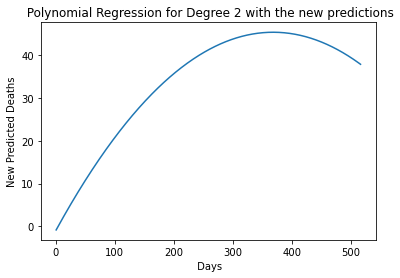

In [42]:
plt.plot( X2 , y_poly_pred_d )
plt.xlabel(" Days")
plt.ylabel("New Predicted Deaths")
plt.title(" Polynomial Regression for Degree 2 with the new predictions" )
plt.show()

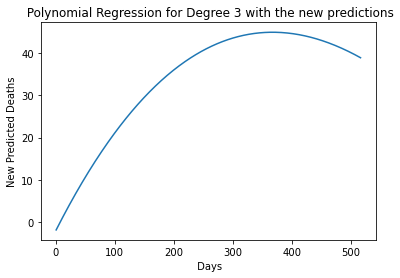

In [43]:
plt.plot( X2 , y_poly_pred3d )
plt.xlabel(" Days")
plt.ylabel("New Predicted Deaths")
plt.title(" Polynomial Regression for Degree 3 with the new predictions" )
plt.show()

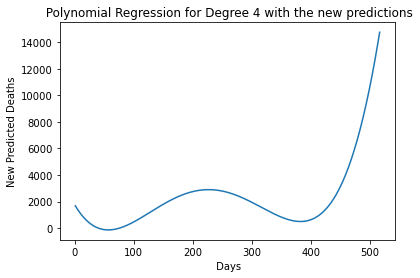

In [44]:
plt.plot( X2 , y_poly_pred4d )
plt.xlabel(" Days")
plt.ylabel("New Predicted Deaths")
plt.title(" Polynomial Regression for Degree 4 with the new predictions" )
plt.show()

### Confidence Interval

#### The shaded area around the regression line is the upper and lower bounds of the confidence Intervals

<AxesSubplot:>

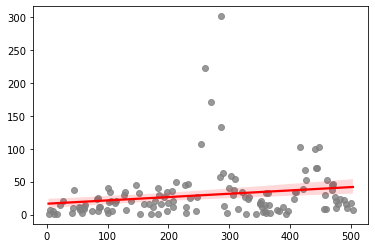

In [45]:
import seaborn as sns
#ax = sns.regplot( X2, y2, ci=80)

sns.regplot(x=x_test_t, y = y_test_t, data= AL_data_groupedBydate, scatter_kws={"color": "grey"}, line_kws={"color": "red"})

### Inference for Alabama State: 

* The cases and deaths seem to be increasing in both the models.
* For Linear Regression model , the regression line seems to fit the data points in an increasing manner. 
* The confidence intervals can also be viewed along the regression line. 
* The prediction line and trends also seem increasing for cases and deaths. 
* For Non-Linear, the regression line seems to be increasing for both the cases and deaths. 
* The regression line with polynomial degree 4 seems to best fit the line compared to other degrees. 

### Task 2 : Identify which counties are most at risk. Model for top 5 counties with cases within a state and describe their trends.

### Linear regression on Top 5 counties of the ALABAMA State

#### I identified the top  5 counties at risk and will be performing Linear and Non Linear Regression on all the counties.

I am reusing my code which I used for the state of ALBAMA to model the linear and non linear regression for Cases and Deaths

After sorting the data cases wise the county that had highest Cases and deaths are given below

1. Winston County 
2. Hale County 
3. Franklin County 
4. Clay County 
5. Clarke County 

In [46]:
#Sorting the data to get the counties with the highest cases
AL_data = AL_data.sort_values(['Num of Cases per day'], ascending = [False])
AL_data = AL_data.sort_values(['Num of Deaths per day'], ascending = [False])

In [127]:
#Top 5 Al counties with high deaths and cases
five_county_data_top = AL_data[AL_data["County_Name"].isin(["winston county","hale county", "franklin county","clay county","clarke county"])]
#five_county_data_top

In [128]:
five_county_data_top = five_county_data_top.groupby("Date").sum().reset_index()

In [129]:
five_county_data_top = five_county_data_top.assign( Days =[1 + i for i in range(len(five_county_data_top))])[['Days'] + five_county_data_top.columns.tolist()]

In [130]:
five_county_data_top = five_county_data_top[(five_county_data_top[['Num of Cases per day']] != 0).any(axis=1)]
five_county_data_top = five_county_data_top[(five_county_data_top[['Num of Deaths per day']] != 0).any(axis=1)]

In [131]:
five_county_data_top = five_county_data_top.drop(columns=["countyFIPS" , "population" ,"Confirmed" , "Deaths"])
five_county_data_top.tail()

,Days,Date,Num of Cases per day,Num of Deaths per day
742,743,2022-02-03,0.0,0.0
743,744,2022-02-04,465.0,3.0
744,745,2022-02-05,0.0,0.0
745,746,2022-02-06,0.0,0.0
746,747,2022-02-07,156.0,0.0


In [52]:
r = five_county_data_top.pop('Days')
five_county_data_top = pd.concat([five_county_data_top, r], 1)
five_county_data_top

,Date,Num of Cases per day,Num of Deaths per day,Days
0,2020-01-23,0.0,0.0,1
1,2020-01-24,0.0,0.0,2
2,2020-01-25,0.0,0.0,3
3,2020-01-26,0.0,0.0,4
4,2020-01-27,0.0,0.0,5
...,...,...,...,...
742,2022-02-03,0.0,0.0,743
743,2022-02-04,465.0,3.0,744
744,2022-02-05,0.0,0.0,745
745,2022-02-06,0.0,0.0,746


### Linear Regression for Top 5 counties -- New Cases 

In [53]:
X1_counties = five_county_data_top[['Days']].to_numpy()
y1_counties = five_county_data_top['Num of Cases per day'].to_numpy()

In [54]:
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(X1_counties, y1_counties)

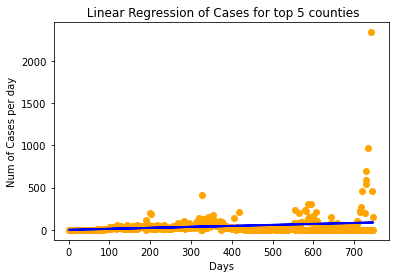

In [55]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train_c, y_train_c)
plt.scatter(x_train_c, y_train_c, color='orange')
plt.plot(x_train_c, model.predict(x_train_c),color='blue', linewidth=2)
plt.xlabel('Days')
plt.title(' Linear Regression of Cases for top 5 counties')
plt.ticklabel_format(style='plain')
plt.ylabel('Num of Cases per day')
plt.show()

In [56]:
modelPred_counties_cases = model.predict(x_test_c)

In [57]:
cal_rmse(y_test_c, modelPred_counties_cases)

MSE: 15706.62057198589
RMSE: 125.32605703518279


### Linear Regression for Top 5 counties -- New Deaths

In [58]:
X2_counties = five_county_data_top[['Days']]
y2_counties = five_county_data_top['Num of Deaths per day']

In [59]:
x_train_cd, x_test_cd, y_train_cd, y_test_cd = train_test_split(X2_counties, y2_counties)

In [60]:
x_train_cd = x_train_cd.to_numpy()

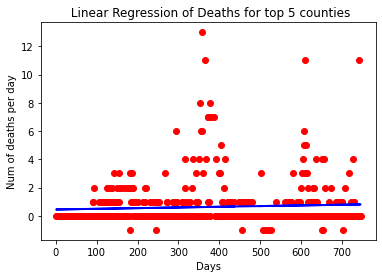

In [61]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train_cd, y_train_cd)
plt.scatter(x_train_cd, y_train_cd,  color='red')
plt.plot(x_train_cd, model.predict(x_train_cd), color='blue', linewidth=2)
plt.xlabel('Days')
plt.title(' Linear Regression of Deaths for top 5 counties')
plt.ticklabel_format(style='plain')
plt.ylabel('Num of deaths per day')
plt.show()

In [62]:
modelPred_counties_deaths = model.predict(x_test_cd)


In [63]:
#calculating RMSE values from the above defined function
cal_rmse(y_test_cd, modelPred_counties_deaths)

MSE: 2.4717781218910564
RMSE: 1.5721889587104523


###  County Wise Modelling : Winston  county linear regression model  for new cases

In [64]:
winston_county = AL_data[AL_data["County_Name"]== "winston county"]
#winston_county = winston_county[(winston_county[['Num of Cases per day']] != 0).any(axis=1)]
#winston_county = winston_county[(winston_county[['Num of Deaths per day']] != 0).any(axis=1)]
#winston_county

In [65]:
X1_winston_county = five_county_data_top[['Days']]
y1_winston_county = five_county_data_top['Num of Cases per day']

In [66]:
z1_winston_county = X1_winston_county.to_numpy()

In [67]:
x_train_winston_county, x_test_winston_county, y_train_winston_county, y_test_winston_county = train_test_split(X1_winston_county, y1_winston_county)

In [68]:
x_train_winston_county = x_train_winston_county.to_numpy()

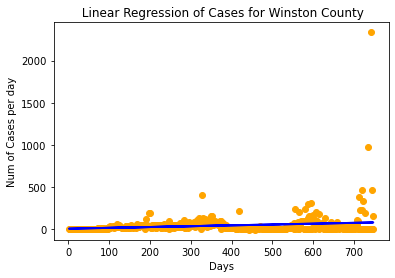

In [69]:
from sklearn.linear_model import LinearRegression
model_winston_county = LinearRegression()
model_winston_county.fit(x_train_winston_county, y_train_winston_county)
plt.scatter(x_train_winston_county, y_train_winston_county, color='orange')
plt.plot(x_train_winston_county, model_winston_county.predict(x_train_winston_county),color='blue', linewidth=2)
plt.xlabel('Days')
plt.title(' Linear Regression of Cases for Winston County')
plt.ticklabel_format(style='plain')
plt.ylabel('Num of Cases per day')
plt.show()

In [70]:
modelPred_winstoncounty_cases = model_winston_county.predict(x_test_winston_county)
cal_rmse(y_test_winston_county, modelPred_winstoncounty_cases)

MSE: 19773.183768138893
RMSE: 140.61715317890238


###  Hale  county linear regression model

In [71]:
X1_hale = five_county_data_top[['Days']]
y1_hale = five_county_data_top['Num of Cases per day']
z1_hale = X1_hale.to_numpy()

x_train_hale, x_test_hale, y_train_hale, y_test_hale = train_test_split(X1_hale, y1_hale)
x_train_hale = x_train_hale.to_numpy()

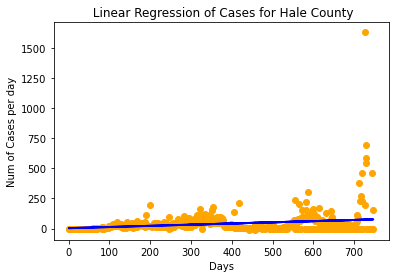

In [72]:
from sklearn.linear_model import LinearRegression
model_hale = LinearRegression()
model_hale.fit(x_train_hale, y_train_hale)
plt.scatter(x_train_hale, y_train_hale, color='orange')
plt.plot(x_train_hale, model_hale.predict(x_train_hale),color='blue', linewidth=2)
plt.xlabel('Days')
plt.title(' Linear Regression of Cases for Hale County')
plt.ticklabel_format(style='plain')
plt.ylabel('Num of Cases per day')
plt.show()

In [73]:
modelPred_hale_cases = model_hale.predict(x_test_hale)
cal_rmse(y_test_hale, modelPred_hale_cases)

MSE: 35064.62278450899
RMSE: 187.2555013464464


### Franklin county linear regression model

In [74]:
X1_Franklin = five_county_data_top[['Days']]
y1_Franklin = five_county_data_top['Num of Cases per day']
z1_Franklin = X1_Franklin.to_numpy()

x_train_Franklin, x_test_Franklin, y_train_Franklin, y_test_Franklin = train_test_split(X1_hale, y1_hale)
x_train_Franklin = x_train_Franklin.to_numpy()

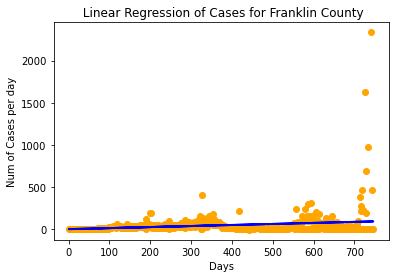

In [75]:
from sklearn.linear_model import LinearRegression
model_franklin = LinearRegression()
model_franklin.fit(x_train_Franklin, y_train_Franklin)
plt.scatter(x_train_Franklin, y_train_Franklin, color='orange')
plt.plot(x_train_Franklin, model_franklin.predict(x_train_Franklin),color='blue', linewidth=2)
plt.xlabel('Days')
plt.title(' Linear Regression of Cases for Franklin County')
plt.ticklabel_format(style='plain')
plt.ylabel('Num of Cases per day')
plt.show()

In [76]:
modelPred_franklin_cases = model_franklin.predict(x_test_Franklin)
cal_rmse(y_test_Franklin , modelPred_franklin_cases)

MSE: 4705.674966879857
RMSE: 68.59792246766557


### Clay county linear regression model

In [77]:
X1_clay = five_county_data_top[['Days']]
y1_clay = five_county_data_top['Num of Cases per day']
z1_clay = X1_clay.to_numpy()

x_train_clay , x_test_clay , y_train_clay , y_test_clay = train_test_split(X1_clay, y1_clay)
x_train_clay = x_train_clay.to_numpy()

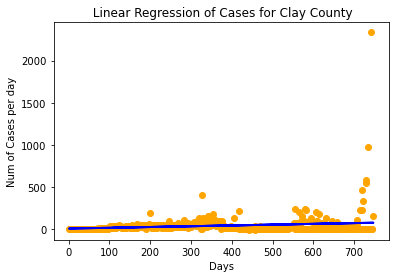

In [78]:
from sklearn.linear_model import LinearRegression
model_clay = LinearRegression()
model_clay.fit(x_train_clay, y_train_clay)
plt.scatter(x_train_clay, y_train_clay, color='orange')
plt.plot(x_train_clay, model_clay.predict(x_train_clay),color='blue', linewidth=2)
plt.xlabel('Days')
plt.title(' Linear Regression of Cases for Clay County')
plt.ticklabel_format(style='plain')
plt.ylabel('Num of Cases per day')
plt.show()

In [79]:
modelPred_franklin_cases = model_franklin.predict(x_test_Franklin)
cal_rmse(y_test_Franklin , modelPred_franklin_cases)

MSE: 4705.674966879857
RMSE: 68.59792246766557


### Clarke county linear regression model

In [80]:
X1_Clarke = five_county_data_top[['Days']]
y1_Clarke = five_county_data_top['Num of Cases per day']
z1_Clarke = X1_Clarke.to_numpy()

x_train_Clarke, x_test_Clarke, y_train_Clarke, y_test_Clarke = train_test_split(X1_hale, y1_hale)
x_train_Clarke = x_train_Clarke.to_numpy()

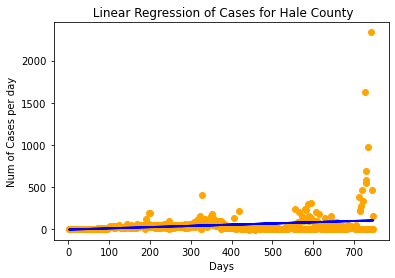

In [81]:
from sklearn.linear_model import LinearRegression
model_Clarke = LinearRegression()
model_Clarke.fit(x_train_Clarke, y_train_Clarke)
plt.scatter(x_train_Clarke, y_train_Clarke, color='orange')
plt.plot(x_train_Clarke, model_Clarke.predict(x_train_Clarke),color='blue', linewidth=2)
plt.xlabel('Days')
plt.title(' Linear Regression of Cases for Hale County')
plt.ticklabel_format(style='plain')
plt.ylabel('Num of Cases per day')
plt.show()

In [82]:
modelPred_Clarke_cases = model_Clarke.predict(x_test_Clarke)
cal_rmse(y_test_Clarke , modelPred_Clarke_cases)

MSE: 2480.7188931901824
RMSE: 49.80681573028116


### County Wise Linear Regression For deaths

### Winston County Deaths

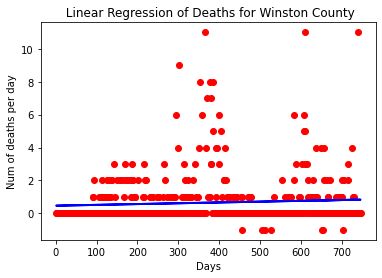

MSE: 2.8231745967887303
RMSE: 1.680230518943377


In [83]:
X2_winston_county = five_county_data_top[['Days']]
y2_winston_county = five_county_data_top['Num of Deaths per day']

x_train_winston_county_deaths, x_test_winston_county_deaths, y_train_winston_county_deaths, y_test_winston_county_deaths = train_test_split(X2_winston_county, y2_winston_county)
x_train_winston_county_deaths = x_train_winston_county_deaths.to_numpy()

from sklearn.linear_model import LinearRegression
model_winstonCountydeaths = LinearRegression()
model_winstonCountydeaths.fit(x_train_winston_county_deaths, y_train_winston_county_deaths)
plt.scatter(x_train_winston_county_deaths, y_train_winston_county_deaths,  color='red')
plt.plot(x_train_winston_county_deaths, model_winstonCountydeaths.predict(x_train_winston_county_deaths), color='blue', linewidth=2)
plt.xlabel('Days')
plt.title(' Linear Regression of Deaths for Winston County')
plt.ticklabel_format(style='plain')
plt.ylabel('Num of deaths per day')
plt.show()

modelPred_winstoncountydeaths = model_winstonCountydeaths.predict(x_test_winston_county_deaths)

#calculating RMSE values from the above defined function
cal_rmse(y_test_winston_county_deaths, modelPred_winstoncountydeaths)

### Hale County Deaths 

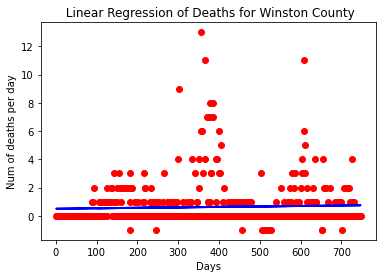

MSE: 2.8011679580167357
RMSE: 1.6736690108909633


In [84]:
X2_hale_county = five_county_data_top[['Days']]
y2_hale_county = five_county_data_top['Num of Deaths per day']

x_train_hale_county_deaths, x_test_hale_county_deaths, y_train_hale_county_deaths, y_test_hale_county_deaths = train_test_split(X2_hale_county, y2_hale_county)
x_train_hale_county_deaths = x_train_hale_county_deaths.to_numpy()

from sklearn.linear_model import LinearRegression
model_haleCountydeaths = LinearRegression()
model_haleCountydeaths.fit(x_train_hale_county_deaths, y_train_hale_county_deaths)
plt.scatter(x_train_hale_county_deaths, y_train_hale_county_deaths,  color='red')
plt.plot(x_train_hale_county_deaths, model_haleCountydeaths.predict(x_train_hale_county_deaths), color='blue', linewidth=2)
plt.xlabel('Days')
plt.title(' Linear Regression of Deaths for Winston County')
plt.ticklabel_format(style='plain')
plt.ylabel('Num of deaths per day')
plt.show()

modelPred_halecountydeaths = model_haleCountydeaths.predict(x_test_hale_county_deaths)

#calculating RMSE values from the above defined function
cal_rmse(y_test_hale_county_deaths, modelPred_winstoncountydeaths)

### Franklin County Deaths : 

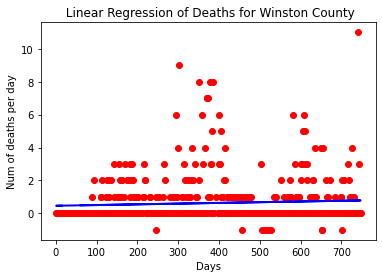

MSE: 3.657093550003453
RMSE: 1.9123528832314012


In [85]:
X2_franklin_county = five_county_data_top[['Days']]
y2_franklin_county = five_county_data_top['Num of Deaths per day']

x_train_franklin_county_deaths, x_test_franklin_county_deaths, y_train_franklin_county_deaths, y_test_franklin_county_deaths = train_test_split(X2_franklin_county, y2_franklin_county)
x_train_franklin_county_deaths = x_train_franklin_county_deaths.to_numpy()

from sklearn.linear_model import LinearRegression
model_frankCountydeaths = LinearRegression()
model_frankCountydeaths.fit(x_train_franklin_county_deaths, y_train_franklin_county_deaths)
plt.scatter(x_train_franklin_county_deaths, y_train_franklin_county_deaths,  color='red')
plt.plot(x_train_franklin_county_deaths, model_frankCountydeaths.predict(x_train_franklin_county_deaths), color='blue', linewidth=2)
plt.xlabel('Days')
plt.title(' Linear Regression of Deaths for Winston County')
plt.ticklabel_format(style='plain')
plt.ylabel('Num of deaths per day')
plt.show()

modelPred_frankcountydeaths = model_frankCountydeaths.predict(x_test_franklin_county_deaths)

#calculating RMSE values from the above defined function
cal_rmse(y_test_franklin_county_deaths, modelPred_frankcountydeaths)

### Clay County New Daeths

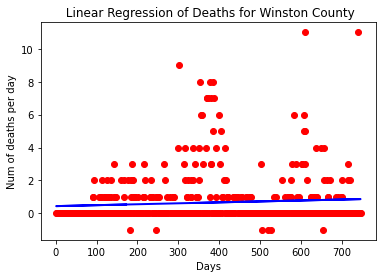

MSE: 2.763446685367486
RMSE: 1.662361779327077


In [86]:
X2_clay_county = five_county_data_top[['Days']]
y2_clay_county = five_county_data_top['Num of Deaths per day']

x_train_clay_county_deaths, x_test_clay_county_deaths, y_train_clay_county_deaths, y_test_clay_county_deaths = train_test_split(X2_clay_county, y2_clay_county)
x_train_clay_county_deaths = x_train_clay_county_deaths.to_numpy()

from sklearn.linear_model import LinearRegression
model_clayCountydeaths = LinearRegression()
model_clayCountydeaths.fit(x_train_clay_county_deaths, y_train_clay_county_deaths)
plt.scatter(x_train_clay_county_deaths, y_train_clay_county_deaths,  color='red')
plt.plot(x_train_clay_county_deaths, model_clayCountydeaths.predict(x_train_clay_county_deaths), color='blue', linewidth=2)
plt.xlabel('Days')
plt.title(' Linear Regression of Deaths for Winston County')
plt.ticklabel_format(style='plain')
plt.ylabel('Num of deaths per day')
plt.show()

modelPred_claycountydeaths = model_clayCountydeaths.predict(x_test_clay_county_deaths)

#calculating RMSE values from the above defined function
cal_rmse(y_test_clay_county_deaths, modelPred_claycountydeaths)

### Clarke  County New Deaths 

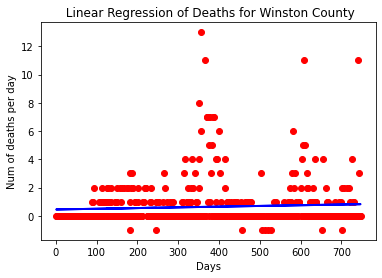

MSE: 2.4575265981330396
RMSE: 1.5676500241230629


In [87]:
X2_clarke_county = five_county_data_top[['Days']]
y2_clarke_county = five_county_data_top['Num of Deaths per day']

x_train_clarke_county_deaths, x_test_clarke_county_deaths, y_train_clarke_county_deaths, y_test_clarke_county_deaths = train_test_split(X2_clarke_county, y2_clarke_county)
x_train_clarke_county_deaths = x_train_clarke_county_deaths.to_numpy()

from sklearn.linear_model import LinearRegression
model_clarkeCountydeaths = LinearRegression()
model_clarkeCountydeaths.fit(x_train_clarke_county_deaths, y_train_clarke_county_deaths)
plt.scatter(x_train_clarke_county_deaths, y_train_clarke_county_deaths,  color='red')
plt.plot(x_train_clarke_county_deaths, model_clarkeCountydeaths.predict(x_train_clarke_county_deaths), color='blue', linewidth=2)
plt.xlabel('Days')
plt.title(' Linear Regression of Deaths for Winston County')
plt.ticklabel_format(style='plain')
plt.ylabel('Num of deaths per day')
plt.show()

modelPred_winstoncountydeaths = model_clarkeCountydeaths.predict(x_test_clarke_county_deaths)

#calculating RMSE values from the above defined function
cal_rmse(y_test_clarke_county_deaths, modelPred_winstoncountydeaths)

### Prediction and TrendLine for  winston county - New Cases and Deaths 

In [88]:
#Predicting the values
new_dates = modelPred_winstoncounty_cases[:10]
new_dates = list(new_dates)
new_dates = np.arange(748,758).reshape(-1,1)

#Predict for deaths
new_dates_deaths = modelPred_winstoncountydeaths[:10]
new_dates_deaths = list(new_dates)
new_dates_deaths = np.arange(748,758).reshape(-1,1)

#new cases forecast for 10 days
new_cases = model_winston_county.predict(new_dates)
new_deaths = model_winstonCountydeaths.predict(new_dates_deaths)

p = pd.DataFrame(new_cases)
r = pd.DataFrame(new_deaths)
df_added = AL_data_groupedBydate
frames = [df_added['Num of Cases per day'], p]
result = pd.concat(frames)
# deaths
frames2 = [df_added['Num of Deaths per day'], r]
result2 = pd.concat(frames2)
p = pd.DataFrame(new_cases)
r = pd.DataFrame(new_deaths)

frames = [df_added['Num of Cases per day'], p]
result = pd.concat(frames)

# deaths
frames2 = [df_added['Num of Deaths per day'], r]
result2 = pd.concat(frames2)

result.rename(columns = {0: 'Num of Cases per day'}, inplace = True)
result2.rename(columns = {0: 'Num of Deaths per day'}, inplace = True)

q = pd.DataFrame(new_dates)
frames1 = [df_added['Days'], q]
result1 = pd.concat(frames1)
result1.rename(columns = {0: 'Days'}, inplace = True)

df1 = pd.concat([result, result1,result2], axis=1)
df1

,Num of Cases per day,Days,Num of Deaths per day
62,144.000000,1,1.000000
64,108.000000,2,1.000000
65,78.000000,3,1.000000
66,108.000000,4,1.000000
67,116.000000,5,2.000000
...,...,...,...
5,78.251958,753,0.840600
6,78.351251,754,0.841090
7,78.450545,755,0.841580
8,78.549839,756,0.842071


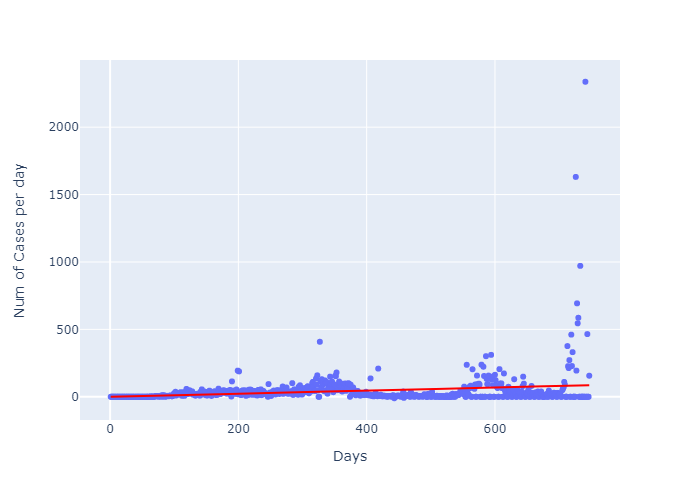

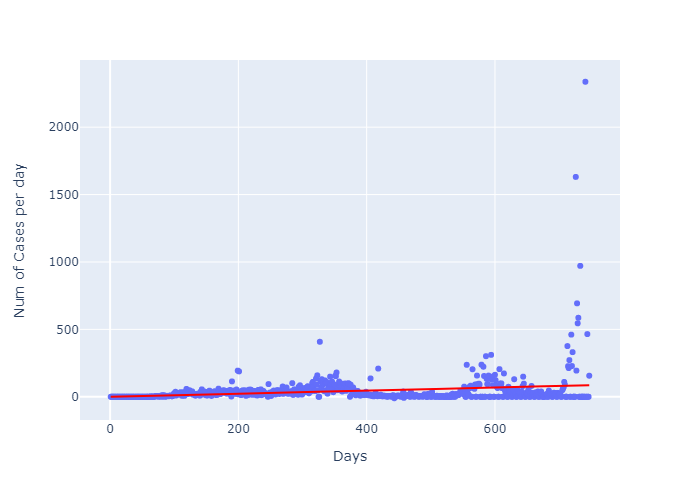

In [93]:
df = five_county_data_top

fig = px.scatter(five_county_data_top, x="Days", y="Num of Cases per day", trendline="ols",trendline_color_override="red")
#fig.show()
fig.write_image("3.png")
Image(filename="3.png")

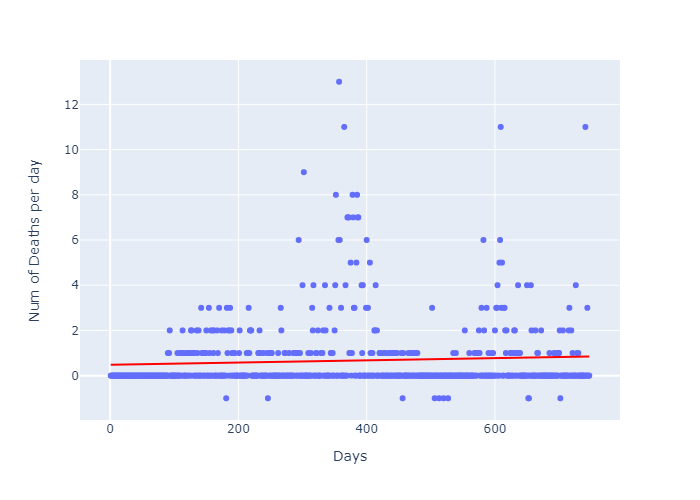

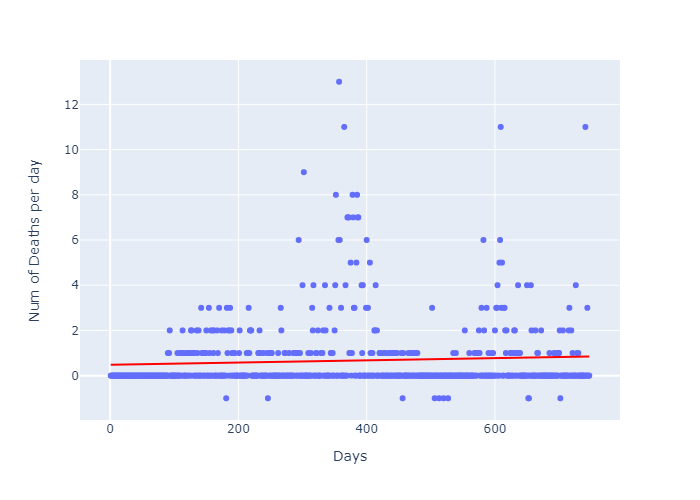

In [94]:
#UPdated forecast for 10 days
fig = px.scatter(five_county_data_top, x="Days", y="Num of Deaths per day", trendline="ols", trendline_color_override="red")
#fig.show()
fig.write_image("4.png")
Image(filename="4.png")


### Prediction and Trend Line for Hale County 

In [89]:
#Predicting the values
new_dates = modelPred_halecountydeaths[:10]
new_dates = list(new_dates)
new_dates = np.arange(748,758).reshape(-1,1)

#Predict for deaths
new_dates_deaths = modelPred_halecountydeaths[:10]
new_dates_deaths = list(new_dates)
new_dates_deaths = np.arange(748,758).reshape(-1,1)

#new cases forecast for 10 days
new_cases = model_winston_county.predict(new_dates)
new_deaths = model_winstonCountydeaths.predict(new_dates_deaths)

p = pd.DataFrame(new_cases)
r = pd.DataFrame(new_deaths)
df_added = AL_data_groupedBydate
frames = [df_added['Num of Cases per day'], p]
result = pd.concat(frames)
# deaths
frames2 = [df_added['Num of Deaths per day'], r]
result2 = pd.concat(frames2)
p = pd.DataFrame(new_cases)
r = pd.DataFrame(new_deaths)

frames = [df_added['Num of Cases per day'], p]
result = pd.concat(frames)

# deaths
frames2 = [df_added['Num of Deaths per day'], r]
result2 = pd.concat(frames2)

result.rename(columns = {0: 'Num of Cases per day'}, inplace = True)
result2.rename(columns = {0: 'Num of Deaths per day'}, inplace = True)

q = pd.DataFrame(new_dates)
frames1 = [df_added['Days'], q]
result1 = pd.concat(frames1)
result1.rename(columns = {0: 'Days'}, inplace = True)

df1 = pd.concat([result, result1,result2], axis=1)
df1

,Num of Cases per day,Days,Num of Deaths per day
62,144.000000,1,1.000000
64,108.000000,2,1.000000
65,78.000000,3,1.000000
66,108.000000,4,1.000000
67,116.000000,5,2.000000
...,...,...,...
5,78.251958,753,0.840600
6,78.351251,754,0.841090
7,78.450545,755,0.841580
8,78.549839,756,0.842071


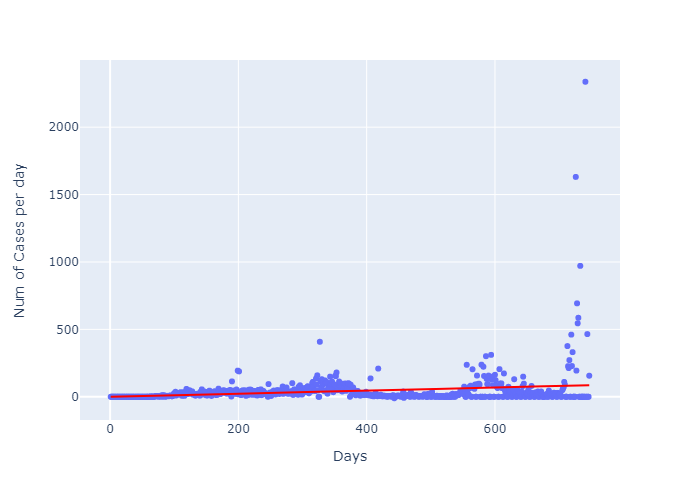

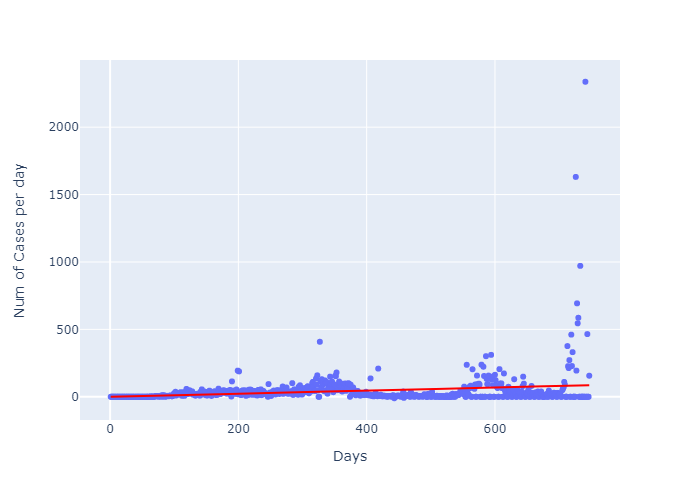

In [96]:
df = five_county_data_top

fig = px.scatter(five_county_data_top, x="Days", y="Num of Cases per day", trendline="ols",trendline_color_override="red")
#fig.show()
fig.write_image("5.png")
Image(filename="5.png")

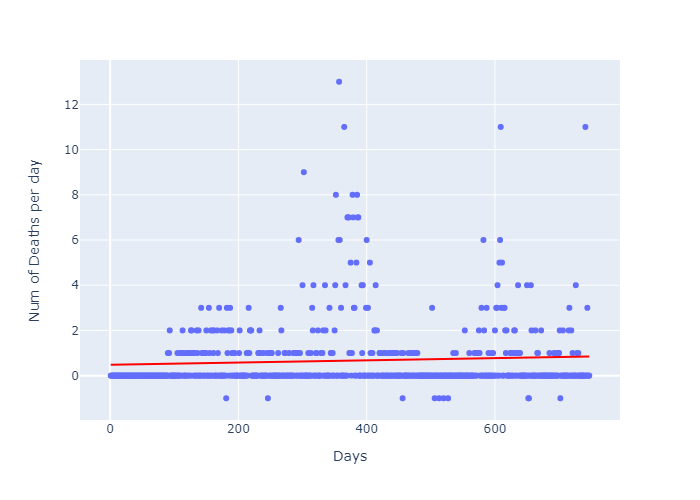

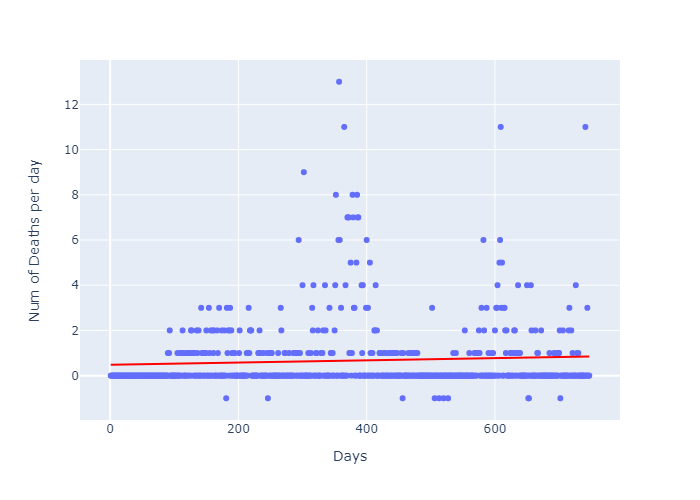

In [97]:
#UPdated forecast 
fig = px.scatter(five_county_data_top, x="Days", y="Num of Deaths per day", trendline="ols", trendline_color_override="red")
#fig.show()
fig.write_image("6.png")
Image(filename="6.png")

### Confidence level for  Hale County

#### The shaded area around the regression line is the upper and lower limits of the intervals. 

<AxesSubplot:>

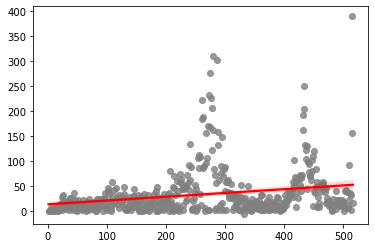

In [90]:
import seaborn as sns

sns.regplot(x= X2, y = y2, data= five_county_data_top, scatter_kws={"color": "grey"}, line_kws={"color": "red"})

### Inference: 

* From the above plots we observe that the trend is the same for new cases when compared to the state and its counties. 
* Similarly the plots trend is same for No. of deaths. 


Thus we infer that with the increase in cases and deaths on county levels the state also saw increase in the cases and deaths. 

### Non Linear Regression for 5 counties - New cases

#### Performing Non Linear Regression by filtering 5 counties which are at the highest risk and showing the trend of the cases. I filtered the dataset with ALABAMA State counties and performed sorting to get the top 5 affected counties and tried to model on the dataset.

In [91]:
X1_counties = five_county_data_top[['Days']]
y1_counties = five_county_data_top['Num of Cases per day']

X1_counties = X1_counties.to_numpy()
y1_counties = y1_counties.to_numpy()

RMSE of degree 2  :  122.6616422577675
RMSE of degree 3 :  119.33762509927956
RMSE of degree 4  :  117.85652174770685


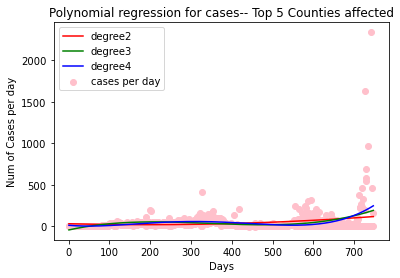

In [92]:
polynomial_feature_2_counties = PolynomialFeatures(degree=2)
x_poly2_counties = polynomial_feature_2_counties.fit_transform(X1_counties)
model_counties = LinearRegression()
model_counties.fit(x_poly2_counties, y1_counties)
y_poly_pred_counties = model_counties.predict(x_poly2_counties)
rmse = np.sqrt(mean_squared_error(y1_counties,y_poly_pred_counties))
print("RMSE of degree 2  : " , rmse)

polynomial_feature_3_counties = PolynomialFeatures(degree=3)
x_poly3_counties = polynomial_feature_3_counties.fit_transform(X1_counties)
poly_reg3_counties = LinearRegression()
poly_reg3_counties.fit(x_poly3_counties, y1_counties)
y_poly_pred3_counties = poly_reg3_counties.predict(x_poly3_counties)
rmse = np.sqrt(mean_squared_error(y1_counties,y_poly_pred3_counties))
print("RMSE of degree 3 : " , rmse)


polynomial_feature_4_counties = PolynomialFeatures(degree=4)
x_poly4_counties = polynomial_feature_4_counties.fit_transform(X1_counties)
poly_reg4_counties = LinearRegression()
poly_reg4_counties.fit(x_poly4_counties, y1_counties)
y_poly_pred4_counties = poly_reg4_counties.predict(x_poly4_counties)

rmse = np.sqrt(mean_squared_error(y1_counties,y_poly_pred4_counties))
print("RMSE of degree 4  : " ,rmse)

plt.scatter(X1_counties, y1_counties, color = 'pink')
plt.plot(X1_counties, model_counties.predict(x_poly2_counties), color = 'r') 
plt.plot(X1_counties, poly_reg3_counties.predict(x_poly3_counties), color = 'g') 
plt.plot(X1_counties, poly_reg4_counties.predict(x_poly4_counties), color = 'b') 
plt.xlabel('Days')
plt.ylabel('Num of Cases per day')
plt.title("Polynomial regression for cases-- Top 5 Counties affected")
plt.legend(["degree2","degree3","degree4" , "cases per day"], loc ="upper left")
plt.show()

### Non Linear Regression for 5 counties for Deaths

#### With the above used data for county I perform modelling on new deaths and try to find the trend

#### The below Non - linear regression is performed on the combined county level information to see the trend of various degrees.

In [93]:
X2_countiesdeaths = five_county_data_top[['Days']]
y2_countiesdeaths = five_county_data_top['Num of Deaths per day']

X2_countiesdeaths = X2_countiesdeaths.to_numpy()
y2_countiesdeaths = y2_countiesdeaths.to_numpy()

RMSE of degree 2  :  132.77661811289798
RMSE of degree 3 :  1.5379481179130106
RMSE of degree 4  :  1.5334378436771392


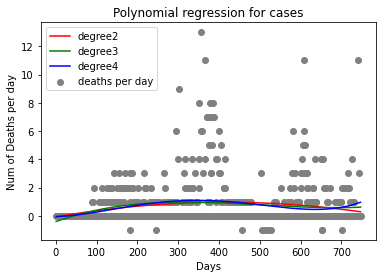

In [94]:
polynomial_feature_2_countiesdeaths = PolynomialFeatures(degree=2)
x_poly2_countiesdeaths = polynomial_feature_2_countiesdeaths.fit_transform(X2_countiesdeaths)
model_countiesdeaths = LinearRegression()
model_countiesdeaths.fit(x_poly2_countiesdeaths, y2_countiesdeaths)
y_poly_pred_countiesdeaths = model_countiesdeaths.predict(x_poly2_countiesdeaths)

rmse = np.sqrt(mean_squared_error(y1_counties,y_poly_pred_countiesdeaths))
print("RMSE of degree 2  : " , rmse)



polynomial_feature_3_countiesdeaths = PolynomialFeatures(degree=3)
x_poly3_countiesdeaths = polynomial_feature_3_countiesdeaths.fit_transform(X2_countiesdeaths)
poly_reg3_countiesdeaths = LinearRegression()
poly_reg3_countiesdeaths.fit(x_poly3_countiesdeaths, y2_countiesdeaths)
y_poly_pred3_countiesdeaths = poly_reg3_countiesdeaths.predict(x_poly3_countiesdeaths)

rmse = np.sqrt(mean_squared_error(y2_countiesdeaths,y_poly_pred3_countiesdeaths))
print("RMSE of degree 3 : " , rmse)


polynomial_feature_4_countiesdeaths = PolynomialFeatures(degree=4)
x_poly4_countiesdeaths = polynomial_feature_4_countiesdeaths.fit_transform(X2_countiesdeaths)
poly_reg4_countiesdeaths = LinearRegression()
poly_reg4_countiesdeaths.fit(x_poly4_countiesdeaths, y2_countiesdeaths)
y_poly_pred4_countiesdeaths = poly_reg4_countiesdeaths.predict(x_poly4_countiesdeaths)

rmse = np.sqrt(mean_squared_error(y2_countiesdeaths,y_poly_pred4_countiesdeaths))
print("RMSE of degree 4  : " ,rmse)

plt.scatter(X2_countiesdeaths, y2_countiesdeaths, color = 'grey')
plt.plot(X2_countiesdeaths, model_countiesdeaths.predict(x_poly2_countiesdeaths), color = 'r') 
plt.plot(X2_countiesdeaths, poly_reg3_countiesdeaths.predict(x_poly3_countiesdeaths), color = 'g') 
plt.plot(X2_countiesdeaths, poly_reg4_countiesdeaths.predict(x_poly4_countiesdeaths), color = 'b') 
plt.xlabel('Days')
plt.ylabel('Num of Deaths per day')
plt.legend(["degree2","degree3","degree4" , "deaths per day"], loc ="upper left")
plt.title("Polynomial regression for cases")
plt.show()

 ### Inference : 


* We observe from the above graphs that the ALABAMA State and the counties of that state follow the same trend line in the        number of cases and number of deaths.

* As the cases rose in the state , the counties also had an increase in the cases. The same trend is observed in deaths as 
  well. 

If you observe the trend lines the degree 4 fits well with the regression line for all the new cases and new deaths. 

### Prediction and Trendline for non linear regression for 5 counties  - New Cases

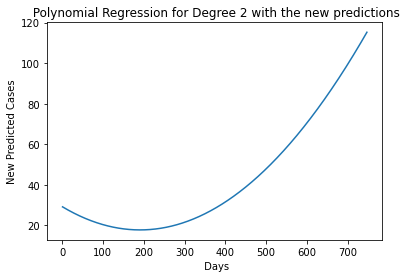

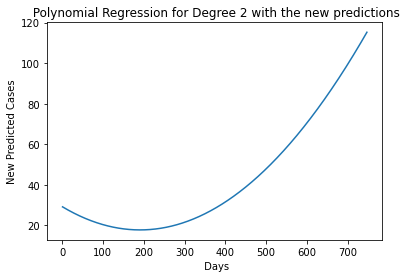

In [103]:
plt.plot( X1_counties , y_poly_pred_counties )
plt.xlabel(" Days")
plt.ylabel("New Predicted Cases")
plt.title(" Polynomial Regression for Degree 2 with the new predictions" )
plt.show()

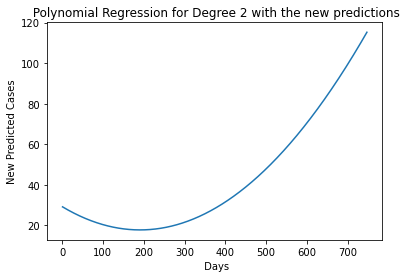

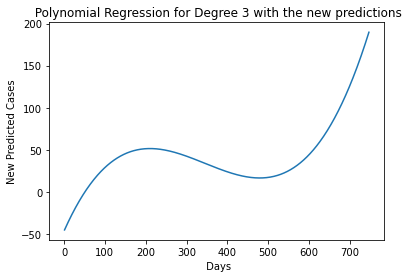

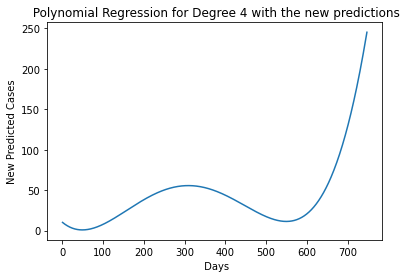

In [95]:

plt.plot( X1_counties , y_poly_pred_counties )
plt.xlabel(" Days")
plt.ylabel("New Predicted Cases")
plt.title(" Polynomial Regression for Degree 2 with the new predictions" )
plt.show()


plt.plot( X1_counties , y_poly_pred3_counties )
plt.xlabel(" Days")
plt.ylabel("New Predicted Cases")
plt.title(" Polynomial Regression for Degree 3 with the new predictions" )
plt.show()

plt.plot( X1_counties , y_poly_pred4_counties )
plt.xlabel(" Days")
plt.ylabel("New Predicted Cases")
plt.title(" Polynomial Regression for Degree 4 with the new predictions" )
plt.show()




### Prediction and Trendline for non linear regression  for 5 counties  - New Deaths

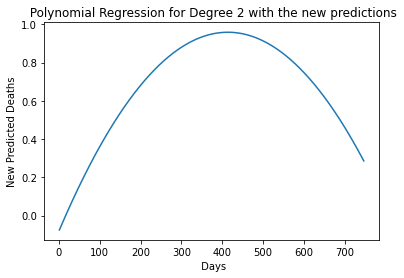

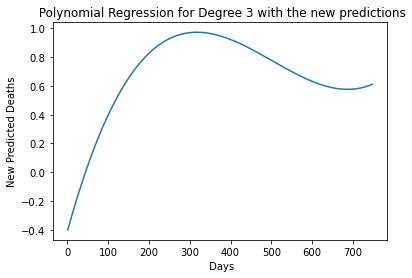

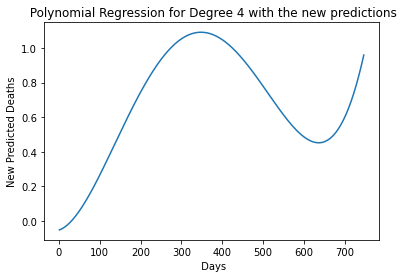

In [96]:
plt.plot( X2_counties , y_poly_pred_countiesdeaths )
plt.xlabel(" Days")
plt.ylabel("New Predicted Deaths")
plt.title(" Polynomial Regression for Degree 2 with the new predictions" )
plt.show()

plt.plot( X2_counties , y_poly_pred3_countiesdeaths )
plt.xlabel(" Days")
plt.ylabel("New Predicted Deaths")
plt.title(" Polynomial Regression for Degree 3 with the new predictions" )
plt.show()



plt.plot( X2_counties , y_poly_pred4_countiesdeaths )
plt.xlabel(" Days")
plt.ylabel("New Predicted Deaths")
plt.title(" Polynomial Regression for Degree 4 with the new predictions" )
plt.show()

### Comparision of State Alabama with other five counties - Trend of New Cases

* We observe that the new cases trend have been increasing  toward the end of the graphs for both the state and the counties. 
* Initial both at the state and the county level the cases were low 
* The ploynomial of degree 4 fits well along the regression line for the both the states and the counties

### Comparision of State Alabama with other five counties - Trend of New Deaths

* We observe that the new deaths trend have been increasing  towards the 300 to 400th days and again the rise was seen from 500-700th days 
* Due to the increasing trend of new cases the rise in deaths cases were seen.
* The ploynomial of degree 4 fits well along the regression line for the both the states and the counties

### Confidence Interval 

#### The shaded area around the regression line is the upper and lower bounds of the confidence Intervals

<AxesSubplot:>

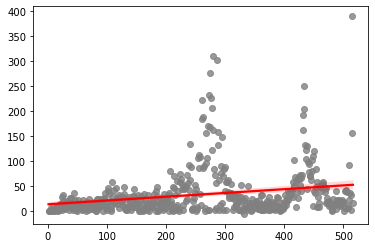

In [97]:

import seaborn as sns

sns.regplot(x= X2, y = y2, data= five_county_data_top, scatter_kws={"color": "grey"}, line_kws={"color": "red"})

### Task 3 : Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.

### For  this task am using the merged dataset from stage 1 that I created as my enrichment dataset  I have worked on dataset

In [98]:
#Read the dataset
covid_hospitalbed_merge = pd.read_csv('../../../../data/covid_hospitalbed_merge.csv')
covid_hospitalbed_merge

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,inpatient_beds,...,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_covid,total_staffed_adult_icu_beds,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,adult_icu_bed_utilization,reporting_cutoff_start,deaths_covid
0,0,statewide unallocated,AL,2020-01-22,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
1,0,statewide unallocated,AL,2020-01-23,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
2,0,statewide unallocated,AL,2020-01-24,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
3,0,statewide unallocated,AL,2020-01-25,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
4,0,statewide unallocated,AL,2020-01-26,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346471,56045,weston county,WY,2022-02-03,1491,17,6927,0,3,1766,...,93,96,134,0.451869,0.120823,0.054367,0.148438,0.410448,2/9/2022,2.0
2346472,56045,weston county,WY,2022-02-04,1496,17,6927,0,3,1766,...,93,96,134,0.451869,0.120823,0.054367,0.148438,0.410448,2/9/2022,2.0
2346473,56045,weston county,WY,2022-02-05,1496,17,6927,0,3,1766,...,93,96,134,0.451869,0.120823,0.054367,0.148438,0.410448,2/9/2022,2.0
2346474,56045,weston county,WY,2022-02-06,1496,17,6927,0,3,1766,...,93,96,134,0.451869,0.120823,0.054367,0.148438,0.410448,2/9/2022,2.0


### Filtered the datafrme for ALABAMA State  and performed the suming of all the cases.

In [99]:
#Retrieving the data with State = 'AL'
covid_hospitalbed_merge_AL = covid_hospitalbed_merge[covid_hospitalbed_merge['State']=="AL"]
covid_hospitalbed_merge_AL.head()

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,inpatient_beds,...,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_covid,total_staffed_adult_icu_beds,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,adult_icu_bed_utilization,reporting_cutoff_start,deaths_covid
0,0,statewide unallocated,AL,2020-01-22,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
1,0,statewide unallocated,AL,2020-01-23,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
2,0,statewide unallocated,AL,2020-01-24,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
3,0,statewide unallocated,AL,2020-01-25,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
4,0,statewide unallocated,AL,2020-01-26,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0


In [100]:
#Retrieving the data with State = 'NC'
covid_hospitalbed_merge_NC = covid_hospitalbed_merge[covid_hospitalbed_merge['State']=="NC"]
covid_hospitalbed_merge_NC.tail()

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,inpatient_beds,...,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_covid,total_staffed_adult_icu_beds,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,adult_icu_bed_utilization,reporting_cutoff_start,deaths_covid
1501231,37199,yancey county,NC,2022-02-03,4425,46,18069,7,109,23252,...,3850,3510,2306,0.803845,0.214769,0.172751,0.305667,0.856895,2/9/2022,48.0
1501232,37199,yancey county,NC,2022-02-04,4439,48,18069,7,109,23252,...,3850,3510,2306,0.803845,0.214769,0.172751,0.305667,0.856895,2/9/2022,48.0
1501233,37199,yancey county,NC,2022-02-05,4439,48,18069,7,109,23252,...,3850,3510,2306,0.803845,0.214769,0.172751,0.305667,0.856895,2/9/2022,48.0
1501234,37199,yancey county,NC,2022-02-06,4439,48,18069,7,109,23252,...,3850,3510,2306,0.803845,0.214769,0.172751,0.305667,0.856895,2/9/2022,48.0
1501235,37199,yancey county,NC,2022-02-07,4491,49,18069,7,109,23252,...,3850,3510,2306,0.803845,0.214769,0.172751,0.305667,0.856895,2/9/2022,48.0


In [101]:
#Remove the unallocated county from the dataset
covid_hospitalbed_merge_AL = covid_hospitalbed_merge_AL[covid_hospitalbed_merge_AL['County_Name']!='statewide unallocated']
covid_hospitalbed_merge_NC = covid_hospitalbed_merge_NC[covid_hospitalbed_merge_NC['County_Name']!='statewide unallocated']

In [102]:
#Find the difference of the two columns Confirmed and Deaths for NC state
covid_hospitalbed_merge_AL['Num of Cases per day'] = covid_hospitalbed_merge_AL['Confirmed'].diff()
covid_hospitalbed_merge_AL['Num of Deaths per day'] = covid_hospitalbed_merge_AL['Deaths'].diff()
covid_hospitalbed_merge_AL = covid_hospitalbed_merge_AL.drop([748])

In [103]:
#Find the difference of the two columns Confirmed and Deaths
covid_hospitalbed_merge_NC['Num of Cases per day'] = covid_hospitalbed_merge_NC['Confirmed'].diff()
covid_hospitalbed_merge_NC['Num of Deaths per day'] = covid_hospitalbed_merge_NC['Deaths'].diff()
covid_hospitalbed_merge_NC = covid_hospitalbed_merge_NC.drop([1426436])

In [104]:
# removing the row that contains NAN 
covid_hospitalbed_merge_AL= covid_hospitalbed_merge_AL[covid_hospitalbed_merge_AL['Date'] != '2020-01-22']
covid_hospitalbed_merge_AL['Date'] = covid_hospitalbed_merge_AL.Date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))

#For NC 
# removing the row that contains NAN 
covid_hospitalbed_merge_NC= covid_hospitalbed_merge_NC[covid_hospitalbed_merge_NC['Date'] != '2020-01-22']
covid_hospitalbed_merge_NC['Date'] = covid_hospitalbed_merge_NC.Date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))

In [105]:
covid_hospitalbed_merge_AL = covid_hospitalbed_merge_AL.groupby("Date").sum().reset_index()


covid_hospitalbed_merge_NC = covid_hospitalbed_merge_NC.groupby("Date").sum().reset_index()
covid_hospitalbed_merge_NC

,Date,countyFIPS,Confirmed,Deaths,population,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,inpatient_beds,inpatient_beds_used,inpatient_beds_used_covid,...,total_adult_patients_hospitalized_confirmed_covid,total_staffed_adult_icu_beds,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,adult_icu_bed_utilization,deaths_covid,Num of Cases per day,Num of Deaths per day
0,2020-01-23,3710000,0,0,10488084,700,10900,2325200,1869100,397000,...,351000,230600,80.384483,21.476873,17.27514,30.566711,85.689506,4800.0,0.0,0.0
1,2020-01-24,3710000,0,0,10488084,700,10900,2325200,1869100,397000,...,351000,230600,80.384483,21.476873,17.27514,30.566711,85.689506,4800.0,0.0,0.0
2,2020-01-25,3710000,0,0,10488084,700,10900,2325200,1869100,397000,...,351000,230600,80.384483,21.476873,17.27514,30.566711,85.689506,4800.0,0.0,0.0
3,2020-01-26,3710000,0,0,10488084,700,10900,2325200,1869100,397000,...,351000,230600,80.384483,21.476873,17.27514,30.566711,85.689506,4800.0,0.0,0.0
4,2020-01-27,3710000,0,0,10488084,700,10900,2325200,1869100,397000,...,351000,230600,80.384483,21.476873,17.27514,30.566711,85.689506,4800.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,2022-02-03,3710000,2456386,21027,10488084,700,10900,2325200,1869100,397000,...,351000,230600,80.384483,21.476873,17.27514,30.566711,85.689506,4800.0,14980.0,123.0
743,2022-02-04,3710000,2468806,21097,10488084,700,10900,2325200,1869100,397000,...,351000,230600,80.384483,21.476873,17.27514,30.566711,85.689506,4800.0,12420.0,70.0
744,2022-02-05,3710000,2468806,21097,10488084,700,10900,2325200,1869100,397000,...,351000,230600,80.384483,21.476873,17.27514,30.566711,85.689506,4800.0,0.0,0.0
745,2022-02-06,3710000,2468806,21097,10488084,700,10900,2325200,1869100,397000,...,351000,230600,80.384483,21.476873,17.27514,30.566711,85.689506,4800.0,0.0,0.0


In [106]:
covid_hospitalbed_merge_AL = covid_hospitalbed_merge_AL.assign( Days =[1 + i for i in range(len(covid_hospitalbed_merge_AL))])[['Days'] + covid_hospitalbed_merge_AL.columns.tolist()]
covid_hospitalbed_merge_NC = covid_hospitalbed_merge_NC.assign( Days =[1 + i for i in range(len(covid_hospitalbed_merge_NC))])[['Days'] + covid_hospitalbed_merge_NC.columns.tolist()]

### Point of no return : 

#### To calculate the point of no return I used columns from the merged dataset with beds and total beds used. So based on these values if the graph line crosses the total utilized bed, then there is no point of return. I tried to apply similar techniques by summing the values and plotting the graph against the new cases / deaths with the no. of days column.  I selected two variables from the data frame with which I can compare. The reason covid and hospital is related because when the cases increase, and the beds are totally accommodated then there will be no point of return. So, I calculate the sum of the columns to perform this task and check if utilized bed cross the total beds then there is no point of return. 

#### Later I compare the data with another state, I chose North Carolina to check the trends of the two states.


#### I referred the below link to plot the graphs and understand the concept of Point of no return
 
  * https://github.com/UNCG-CSE/CSC-405-605_Spring_2022/blob/main/Class_Resources/Lecture_06/Statistics/05_Hypothesis.ipynb
  * http://aassjournal.com/article-1-886-en.pdf
  * https://aclanthology.org/D19-1180.pdf
  * https://www.daytradingbias.com/the-real-secret-of-trend-in-day-trading-finding-the-point-of-no-return/
  * https://www.youtube.com/watch?v=k9KqmzUGgGQ
  * https://datatofish.com/line-chart-python-matplotlib/

In [107]:
tot_beds = covid_hospitalbed_merge_AL['inpatient_beds'].mean()
tot_utilized_beds = covid_hospitalbed_merge_AL['inpatient_beds_used'].mean()

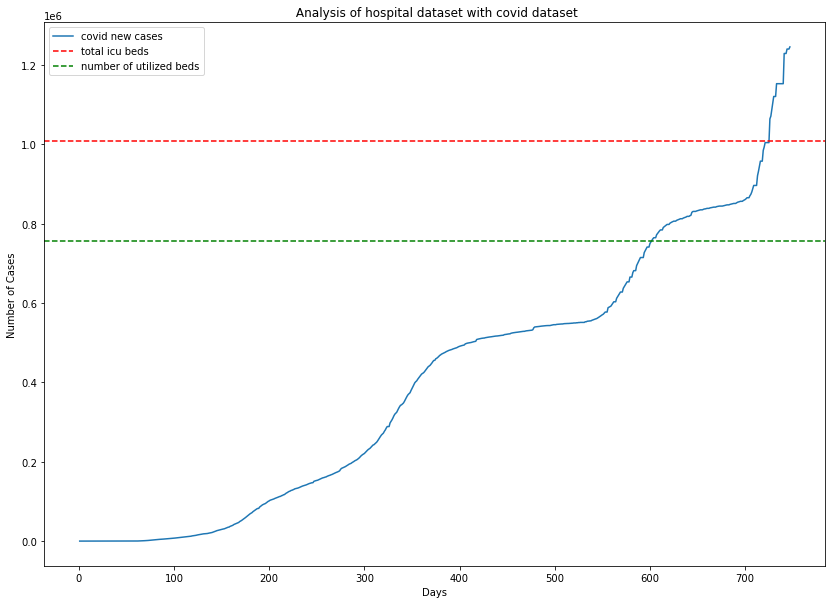

In [108]:
plt. figure(figsize=(14,10))
plt.plot(covid_hospitalbed_merge_AL['Days'], covid_hospitalbed_merge_AL['Confirmed'],label="covid new cases")
plt.axhline(y=tot_beds, color='r', label="total icu beds",linestyle='--')
plt.axhline(y=tot_utilized_beds, color='g', label = "number of utilized beds",linestyle='--')
plt.title(" Analysis of hospital dataset with covid dataset")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.legend()
plt.show()

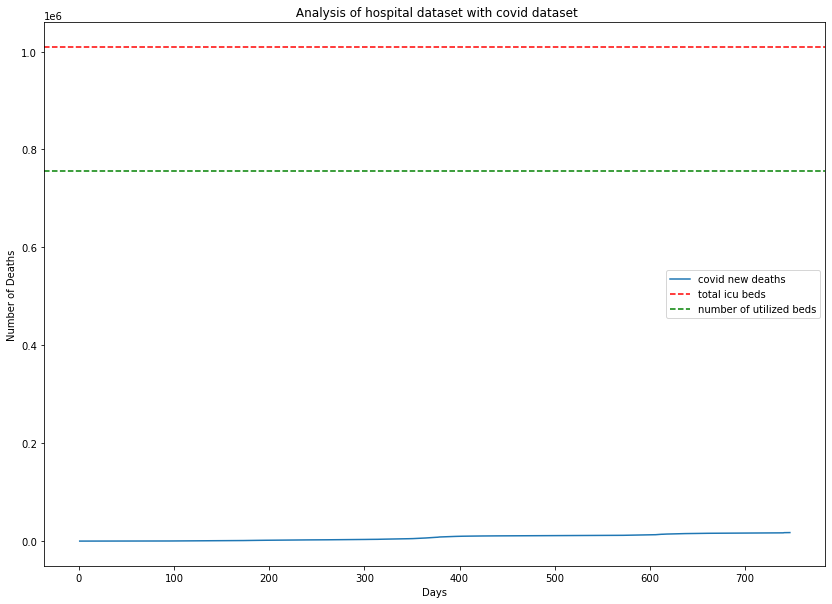

In [109]:
plt. figure(figsize=(14,10))
plt.plot(covid_hospitalbed_merge_AL['Days'], covid_hospitalbed_merge_AL['Deaths'],label="covid new deaths")
plt.axhline(y=tot_beds, color='r', label="total icu beds",linestyle='--')
plt.axhline(y=tot_utilized_beds, color='g', label = "number of utilized beds",linestyle='--')
plt.title(" Analysis of hospital dataset with covid dataset")
plt.xlabel("Days")
plt.ylabel("Number of Deaths")
plt.legend()
plt.show()

### Point of no return for NC state and comparing the trends for each of them

In [110]:
#Retrieving the data with State = 'NC'
covid_hospitalbed_merge_NC.head()

,Days,Date,countyFIPS,Confirmed,Deaths,population,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,inpatient_beds,inpatient_beds_used,...,total_adult_patients_hospitalized_confirmed_covid,total_staffed_adult_icu_beds,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,adult_icu_bed_utilization,deaths_covid,Num of Cases per day,Num of Deaths per day
0,1,2020-01-23,3710000,0,0,10488084,700,10900,2325200,1869100,...,351000,230600,80.384483,21.476873,17.27514,30.566711,85.689506,4800.0,0.0,0.0
1,2,2020-01-24,3710000,0,0,10488084,700,10900,2325200,1869100,...,351000,230600,80.384483,21.476873,17.27514,30.566711,85.689506,4800.0,0.0,0.0
2,3,2020-01-25,3710000,0,0,10488084,700,10900,2325200,1869100,...,351000,230600,80.384483,21.476873,17.27514,30.566711,85.689506,4800.0,0.0,0.0
3,4,2020-01-26,3710000,0,0,10488084,700,10900,2325200,1869100,...,351000,230600,80.384483,21.476873,17.27514,30.566711,85.689506,4800.0,0.0,0.0
4,5,2020-01-27,3710000,0,0,10488084,700,10900,2325200,1869100,...,351000,230600,80.384483,21.476873,17.27514,30.566711,85.689506,4800.0,0.0,0.0


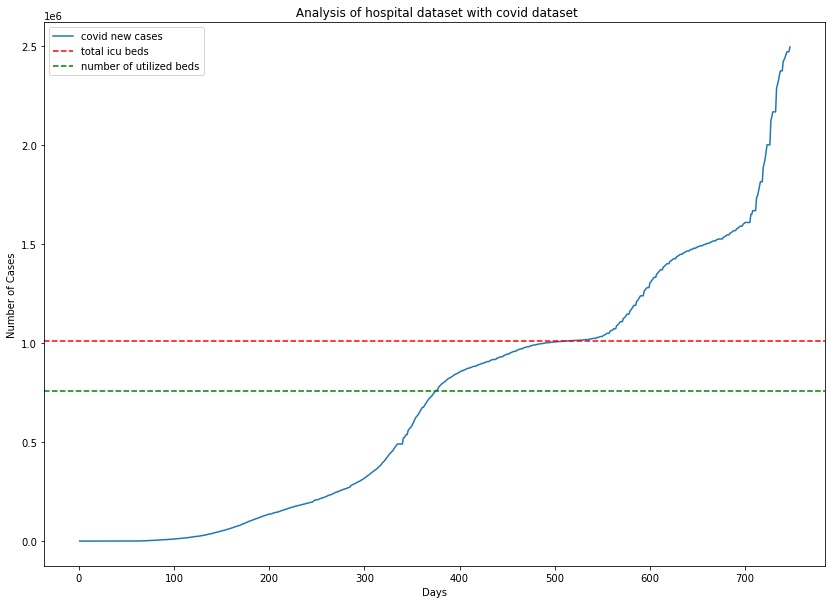

In [111]:
plt. figure(figsize=(14,10))
plt.plot(covid_hospitalbed_merge_NC['Days'], covid_hospitalbed_merge_NC['Confirmed'],label="covid new cases")
plt.axhline(y=tot_beds, color='r', label="total icu beds",linestyle='--')
plt.axhline(y=tot_utilized_beds, color='g', label = "number of utilized beds",linestyle='--')
plt.title(" Analysis of hospital dataset with covid dataset")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.legend()
plt.show()

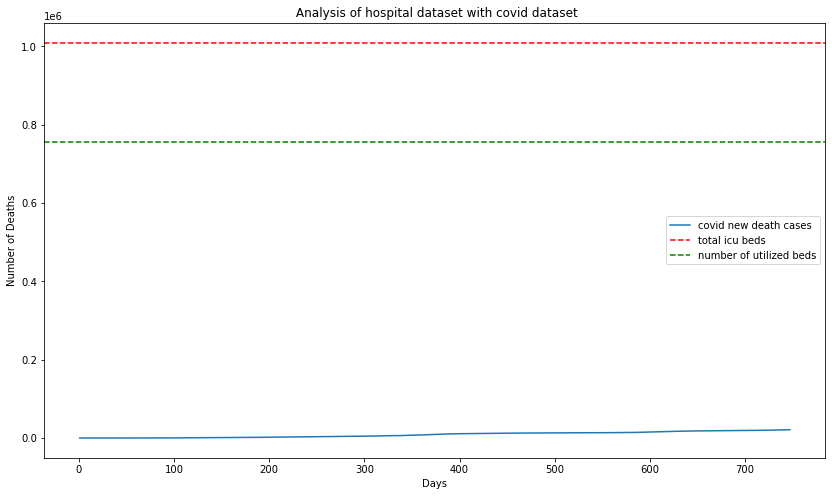

In [112]:
plt. figure(figsize=(14,8))
plt.plot(covid_hospitalbed_merge_NC['Days'], covid_hospitalbed_merge_NC['Deaths'],label="covid new death cases")
plt.axhline(y=tot_beds, color='r', label="total icu beds",linestyle='--')
plt.axhline(y=tot_utilized_beds, color='g', label = "number of utilized beds",linestyle='--')
plt.title(" Analysis of hospital dataset with covid dataset")
plt.xlabel("Days")
plt.ylabel("Number of Deaths")
plt.legend()
plt.show()

### Inference : 

* From the above plots we observe that the trend in both the states for cases and deaths is the same. 
* The border line which explains that whether a parameter has a point of no return or not. 
* I have taken two parameters to compare against the covid dataset. So if the cases increase then there are no beds available.Also the  Number of utilized beds cross above the total ICU beds then there is no point of return.
* In both the states the point of return has not yet arrived as the dataset used doesnt have such values for the utilized bed to cross the total beds. 

###  Hypothesis Testing 

#### I have referred teh below site to accomplish this task : 
  * https://github.com/UNCG-CSE/CSC-405-605_Spring_2022/blob/main/Class_Resources/Lecture_06/Statistics/05_Hypothesis.ipynb

### For this hypothesis I tried to find the mean of the variables of the hospital dataset i.e. total bed and the total beds used. By this we will be able to draw a hypothesis that if the beds utilized is more then the covid cases is rising and also there is increase in deaths. To prove this hypothesis, we calculate the p-value and chi square to show the proposed null hypothesis is accepted or rejected.


In [113]:
#Read the dataset
covid_hospitalbed_merge = pd.read_csv('../../../../data/covid_hospitalbed_merge.csv')

In [114]:
#Retrieving the data with State = 'AL'
covid_hospitalbed_merge_AL_HT = covid_hospitalbed_merge[covid_hospitalbed_merge['State']=="AL"]
covid_hospitalbed_merge_AL_HT.head()

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,inpatient_beds,...,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_covid,total_staffed_adult_icu_beds,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,adult_icu_bed_utilization,reporting_cutoff_start,deaths_covid
0,0,statewide unallocated,AL,2020-01-22,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
1,0,statewide unallocated,AL,2020-01-23,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
2,0,statewide unallocated,AL,2020-01-24,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
3,0,statewide unallocated,AL,2020-01-25,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0
4,0,statewide unallocated,AL,2020-01-26,0,0,0,0,8,15066,...,1839,1662,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0


In [115]:
#Remove the unallocated county from the dataset
covid_hospitalbed_merge_AL_HT = covid_hospitalbed_merge_AL_HT[covid_hospitalbed_merge_AL_HT['County_Name']!='statewide unallocated']
#Find the difference of the two columns Confirmed and Deaths
covid_hospitalbed_merge_AL_HT['Num of Cases per day'] = covid_hospitalbed_merge_AL_HT['Confirmed'].diff()
covid_hospitalbed_merge_AL_HT['Num of Deaths per day'] = covid_hospitalbed_merge_AL_HT['Deaths'].diff()
covid_hospitalbed_merge_AL_HT

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,inpatient_beds,...,total_staffed_adult_icu_beds,inpatient_beds_utilization,percent_of_inpatients_with_covid,inpatient_bed_covid_utilization,adult_icu_bed_covid_utilization,adult_icu_bed_utilization,reporting_cutoff_start,deaths_covid,Num of Cases per day,Num of Deaths per day
748,1001,autauga county,AL,2020-01-22,0,0,55869,0,8,15066,...,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0,NaN,NaN
749,1001,autauga county,AL,2020-01-23,0,0,55869,0,8,15066,...,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0,0.0,0.0
750,1001,autauga county,AL,2020-01-24,0,0,55869,0,8,15066,...,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0,0.0,0.0
751,1001,autauga county,AL,2020-01-25,0,0,55869,0,8,15066,...,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0,0.0,0.0
752,1001,autauga county,AL,2020-01-26,0,0,55869,0,8,15066,...,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50859,1133,winston county,AL,2022-02-03,7057,115,23629,0,8,15066,...,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0,0.0,0.0
50860,1133,winston county,AL,2022-02-04,7183,115,23629,0,8,15066,...,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0,126.0,0.0
50861,1133,winston county,AL,2022-02-05,7183,115,23629,0,8,15066,...,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0,0.0,0.0
50862,1133,winston county,AL,2022-02-06,7183,115,23629,0,8,15066,...,1574,0.748507,0.171831,0.129121,0.282855,0.895172,2/9/2022,28.0,0.0,0.0


In [116]:
# removing the row that contains NAN 
covid_hospitalbed_merge_AL_HT= covid_hospitalbed_merge_AL_HT[covid_hospitalbed_merge_AL_HT['Date'] != '2020-01-22']
covid_hospitalbed_merge_AL_HT['Date'] = covid_hospitalbed_merge_AL_HT.Date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))
covid_hospitalbed_merge_AL_HT = covid_hospitalbed_merge_AL_HT.groupby("Date").sum().reset_index()
covid_hospitalbed_merge_AL_HT.to_csv("hosp.csv")

### As mentioned above I calculate the mean of the Cases  to understand the hypothesis.

This way where the mean of the two variables stand we can derive the null hypothesis is true.

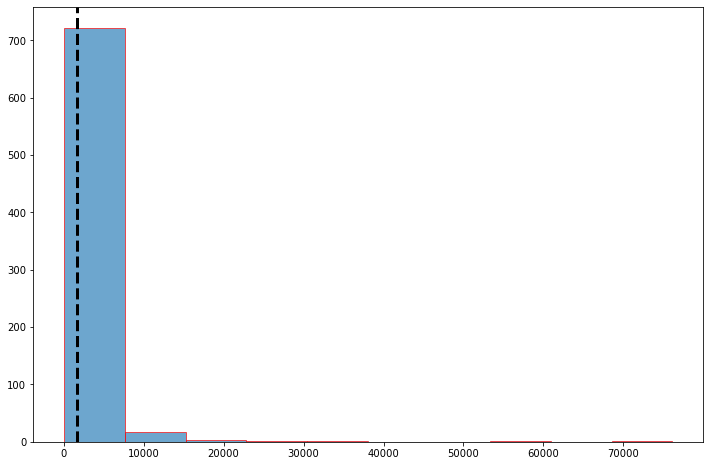

In [117]:
plt.figure(figsize=(12,8))
plt.hist(covid_hospitalbed_merge_AL_HT['Num of Cases per day'], bins=10, edgecolor='r', alpha=0.65)
plt.axvline(covid_hospitalbed_merge_AL_HT['Num of Cases per day'].mean(), color='black', linestyle='dashed', linewidth= 3)

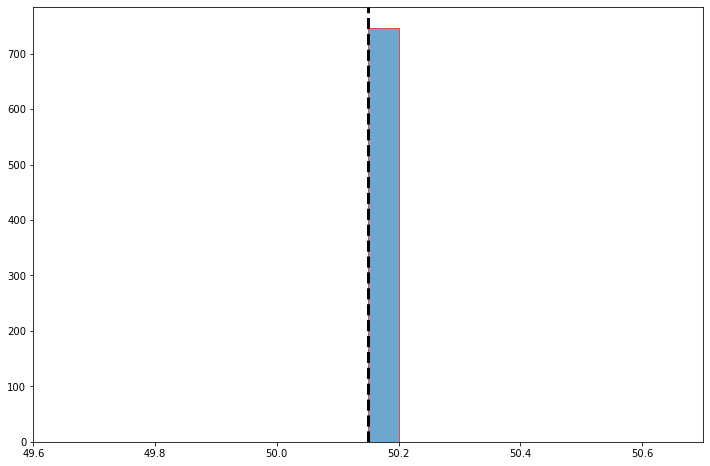

In [118]:
plt.figure(figsize=(12,8))
plt.hist(covid_hospitalbed_merge_AL_HT['inpatient_beds_utilization'], bins=20, edgecolor='r', alpha=0.65)
plt.axvline(covid_hospitalbed_merge_AL_HT['inpatient_beds_utilization'].mean(), color='black', linestyle='dashed', linewidth= 3)

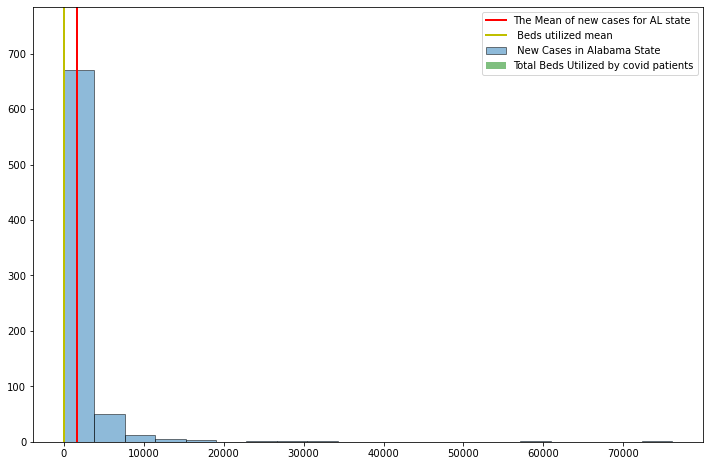

In [119]:
plt.figure(figsize=(12,8))

plt.hist(covid_hospitalbed_merge_AL_HT['Num of Cases per day'], bins=20, edgecolor='k', alpha=0.5, label=' New Cases in Alabama State')
plt.hist(covid_hospitalbed_merge_AL_HT['inpatient_beds_utilization'], bins= 30, color='green', alpha=0.5, label='Total Beds Utilized by covid patients')
plt.axvline(covid_hospitalbed_merge_AL_HT['Num of Cases per day'].mean(), color='r', linewidth=2, label='The Mean of new cases for AL state') 
plt.axvline(covid_hospitalbed_merge_AL_HT['inpatient_beds_utilization'].mean(), color='y',  linewidth=2, label=' Beds utilized mean ') 
plt.legend(loc='upper right')
plt.show()

### From the above computation we see that the pvalue is calculated so the confidence levels and the pvalue are the parameters to accept or  reject a hypothesis. I have referred notes to get the pvalue.

Reference: 
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [132]:
#calculate the Pvalues
from scipy import stats

stats.ttest_ind( a = covid_hospitalbed_merge_AL_HT['Num of Cases per day'], b = covid_hospitalbed_merge_AL_HT['inpatient_beds_utilization'])

Ttest_indResult(statistic=9.989064439230003, pvalue= 0.04213047)


### Chi-Squared Test

### Calculated the Chi-Squared value from the below site. 

* https://towardsdatascience.com/chi-square-test-with-python-d8ba98117626

In [121]:
# create contingency table
data_crosstab = pd.crosstab(covid_hospitalbed_merge_AL_HT['Num of Cases per day'],
                            covid_hospitalbed_merge_AL_HT['inpatient_beds_utilization'],
                           margins=True, margins_name="Total")

# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = 0
rows = covid_hospitalbed_merge_AL_HT['Num of Cases per day'].unique()
columns = covid_hospitalbed_merge_AL_HT['inpatient_beds_utilization'].unique()

for i in columns:
    for j in rows:
        O = data_crosstab[i][j]
        E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
        chi_square += (O-E)**2/E

# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."

if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected since the pvalue is lesser than the threshold."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)


Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 0.026458  and p value is: 0.04213047
Null Hypothesis is rejected since the pvalue is lesser than the threshold.


### My Hypothesis is that with the increase in the beds utilization the number of new  cases and new deaths are increasing. To state the Null hypothesis and Alternate hypothesis I would define it as , 

* Null Hypothesis (Ho): The beds utilization  has no effect on  increase in cases.
* Alternate Hypothesis (Ha): The bed utilization has an effect with the increase in cases.  

I will try to to approve or reject a hypothesis by calculating the mean of the datapoints. As shown in the above plots we can observe the mean of the datapoints for both the variables and come to a conclusion that the proposed experiment is true. The mean for bed utilized is beyond the line of the mean of cases. 


###  We observe that the beds utilized is more than the mean of the cases which proves that the null hypothesis is correct. The two variables beds and cases are increasing and dependant on each other.


Also, The dataset has a negative values which means that there were no beds available and the people who wanted a bed were added to the waitlist. Thus in the graph the beds bin values are hidden as it goes negative. 

#### The pvalue is  0.04213047 which is lesser than the threshold hence the null hypothesis is rejected. 